# Modeling Success Factors of Set Pieces in Soccer in an Expected Possession Value Framework #

## Master Thesis - Dominik Mayer ##

### This Jupyter Notebook contains the results of my master thesis with the goal to develop interpretable models to predict corner kick success in soccer from spatio-temporal and contextual data. For this, raw data of the 2022/23 and 2023/24 Bundesliga has been transformed into relevant features of each action by the team in ball-possession during corner kick possession phases - stored in the file $\verb|events_compressed_processed.pkl|$. This notebook only includes the model training on the already processed feature values and target variable. 

### The Notebook is structured in the following way:

1) <b>Split Dataset:</b> Split the underlying dataset in overall training, validation and test set, define class weight on the training set
2) <b>Model Training using all Features:</b> Using all features, perform hyperparameter search with cross-validation on the training + validation set for Random Forest, XGBoost and Multilayer-Perceptron. Use the best scoring hyperparameters of each architecture to train models on the overall training + validation set and evaluate them on the overall test set.
3) <b>Global Feature Importance:</b> Calculate global feature importances for the best model of each architecture. Combine them in an average and select 15 features.
4) <b>Model Training with reduced Features:</b> Perform another hyperparameter search with cross-validation, using only the 15 selected features. Train model for each architecture with the best scoring parameter combinations on the overall training + validation set, evaluate on the overall test set.
5) <b>Model Interpretation:</b> Use SHAP values to analyze the impact of feature values on the resulting models. Identify feature values that particularly increase or decrease to predicted goal probabilities of the models. Finally analyze the single actions of a successful corner kick possession with the best performing Model (Random Forest) and its SHAP values.

In [ ]:
# import necessary python packages
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, f1_score, make_scorer, log_loss, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import xgboost as xgb
from IPython.display import display, Markdown
# Neural Network (MLP)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#### Define Statics ####

- Columns of dataset containing metadata
- Feature Columns
- Reduced Features after removing high correlations
- Average values over training set for missing values
- Integer encoding of label-valued features 

In [ ]:
# Define columns that are relevant for filtering and data splitting
cols = ['MatchId',
        'SUBTYPE',
        'EventId',
        'CUID1',
        'Club1',
        'possesion_chain',
        'possesion_chain_team',
        'possesion_chain_team_id',
        'spielphase',
        'subphase',
        'time_in_sec_sync',
        'possesion_chain_defending_team']

cols_match_id = ['MatchId']

cols_epv_target = ['epv_success']

cols_kpis = [
    'sp_type',
    'sp_initial_position_x_distance_to_goal',
    'sp_initial_position_y_distance_to_goal',
    'sp_initial_position_distance_to_goal',
    'sp_initial_position_angle_to_goal',
    'sp_initial_position_horizontal_zone',
    'sp_initial_position_vertical_zone',
    'sp_initial_last_line_of_defense',
    'sp_initial_inswing_outswing',
    'sp_initial_marking_type',
    'sp_first_ball_action_type',
    'sp_first_ball_action_execution',
    'sp_first_ball_action_ball_z_max',
    'sp_delivery_time',
    'sp_delivery_distance',
    'sp_delivery_velocity',
    'sp_delivery_end_position_horizontal_zone',
    'sp_delivery_end_position_vertical_zone',
    'sp_delivery_end_position_distance_to_goal',
    'sp_delivery_end_position_angle_to_goal',
    'sp_delivery_in_golden_zone',
    'sp_action',
    'sp_pass_number',
    'sp_duration',
    'sp_position_distance_to_goal',
    'sp_position_angle_to_goal',
    'sp_position_horizontal_zone',
    'sp_position_vertical_zone',
    'sp_numerical_superiority_in_box_offense',
    'sp_numerical_superiority_in_dfb_shot_zone_offense',
    'sp_space_control_in_box_offense',
    'sp_space_control_in_dfb_shot_zone_offense',
    'sp_heights_in_box_offense',
    'sp_heights_shot_zone_offense',
    'sp_avg_speeds_box_offense',
    'sp_avg_speeds_shot_zone_offense',
    'sp_defenders_in_line_of_shot',
    'sp_heights_in_box_defense',
    'sp_heights_shot_zone_defense',
    'sp_defensive_pressure_box',
    'sp_defensive_pressure_shot_zone',
    'sp_early_dropping'
]

all_cols = cols + cols_epv_target + cols_kpis

cols_kpis_final = [
    # Category I: Initial State
    'sp_type',
    'sp_initial_position_x_distance_to_goal',
    'sp_initial_position_y_distance_to_goal',
    'sp_initial_position_distance_to_goal',
    'sp_initial_position_angle_to_goal',
    'sp_initial_position_horizontal_zone',
    'sp_initial_position_vertical_zone',
    'sp_initial_last_line_of_defense',
    'sp_initial_inswing_outswing',
    'sp_initial_marking_type',

    # Category II: Initial Exectution
    'sp_first_ball_action_type',
    'sp_first_ball_action_execution',
    'sp_first_ball_action_ball_z_max',
    'sp_delivery_time',
    'sp_delivery_distance',
    'sp_delivery_velocity',
    'sp_delivery_end_position_horizontal_zone',
    'sp_delivery_end_position_vertical_zone',
    'sp_delivery_end_position_distance_to_goal',
    'sp_delivery_end_position_angle_to_goal',
    'sp_delivery_in_golden_zone',

    # Category III: Game State after Execution
    # 'sp_action',
    'sp_pass_number',
    'sp_duration',
    'sp_position_distance_to_goal',
    'sp_position_angle_to_goal',
    'sp_position_horizontal_zone',
    'sp_position_vertical_zone',

    # Category IV: Attacking Team Performance
    'sp_numerical_superiority_in_box_offense',
    'sp_numerical_superiority_in_dfb_shot_zone_offense',
    'sp_space_control_in_box_offense',
    'sp_space_control_in_dfb_shot_zone_offense',
    
    # 'sp_heights_in_box_offense',
    'sp_heights_in_box_offense_min',  # nachberechnet
    'sp_heights_in_box_offense_max',  # nachberechnet
    'sp_heights_in_box_offense_mean',  # nachberechnet
    'sp_heights_in_box_offense_count',  # nachberechnet
    'sp_heights_in_box_offense_taller_than_defense',  # nachberechnet
    # 'sp_heights_shot_zone_offense',
    'sp_heights_shot_zone_offense_min',  # nachberechnet
    'sp_heights_shot_zone_offense_max',  # nachberechnet
    'sp_heights_shot_zone_offense_mean',  # nachberechnet
    'sp_heights_shot_zone_offense_count',  # nachberechnet
    'sp_heights_shot_zone_offense_taller_than_defense',  # nachberechnet
    # 'sp_avg_speeds_box_offense',
    'sp_avg_speeds_box_offense_min',  # nachberechnet
    'sp_avg_speeds_box_offense_max',  # nachberechnet
    'sp_avg_speeds_box_offense_mean',  # nachberechnet
    # 'sp_avg_speeds_shot_zone_offense',
    'sp_avg_speeds_shot_zone_offense_min',  # nachberechnet
    'sp_avg_speeds_shot_zone_offense_max',  # nachberechnet
    'sp_avg_speeds_shot_zone_offense_mean',  # nachberechnet


    # Category V: Defending Team Performance
    'sp_defenders_in_line_of_shot',
    # 'sp_heights_in_box_defense',
    'sp_heights_in_box_defense_min',  # nachberechnet
    'sp_heights_in_box_defense_max',  # nachberechnet
    'sp_heights_in_box_defense_mean',  # nachberechnet
    # 'sp_heights_shot_zone_defense',
    'sp_heights_shot_zone_defense_min',  # nachberechnet
    'sp_heights_shot_zone_defense_max',  # nachberechnet
    'sp_heights_shot_zone_defense_mean',  # nachberechnet
    # 'sp_defensive_pressure_box',
    'sp_defensive_pressure_box_min',  # nachberechnet
    'sp_defensive_pressure_box_max',  # nachberechnet
    'sp_defensive_pressure_box_mean',  # nachberechnet
    # 'sp_defensive_pressure_shot_zone',
    'sp_defensive_pressure_shot_zone_min',  # nachberechnet
    'sp_defensive_pressure_shot_zone_max',  # nachberechnet
    'sp_defensive_pressure_shot_zone_mean',  # nachberechnet
    'sp_early_dropping'
]

col_nonnumerical = [
    'sp_type',
    'sp_initial_inswing_outswing',
    'sp_initial_marking_type',
    'sp_first_ball_action_type',
    'sp_first_ball_action_execution',
    'sp_action'
]

cols_heights = [
    'sp_heights_in_box_offense',
    'sp_heights_shot_zone_offense',
    'sp_heights_in_box_defense',
    'sp_heights_shot_zone_defense'
]

cols_speeds = [
    'sp_avg_speeds_box_offense',
    'sp_avg_speeds_shot_zone_offense'
]

cols_def_pressure = [
    'sp_defensive_pressure_box',
    'sp_defensive_pressure_shot_zone'
]

# hochkorrelierende Spalten Eckbälle
cols_with_high_correlation = [
    'sp_initial_position_y_distance_to_goal',
    'sp_initial_position_x_distance_to_goal',
    'sp_initial_position_vertical_zone',
    'sp_initial_position_horizontal_zone',
    'sp_initial_position_distance_to_goal',
    'sp_initial_position_angle_to_goal',
    'sp_delivery_end_position_horizontal_zone',
    'sp_delivery_in_golden_zone',
    'sp_first_ball_action_execution',
    'sp_first_ball_action_type',
    'sp_heights_in_box_offense_count',
    'sp_heights_in_box_defense_min',
    'sp_heights_in_box_defense_max',
    'sp_heights_in_box_defense_mean',
    'sp_heights_in_box_offense_min',
    'sp_heights_in_box_offense_max',
    'sp_heights_in_box_offense_mean',
    'sp_heights_in_box_offense_taller_than_defense',
    'sp_heights_shot_zone_defense_min',
    'sp_numerical_superiority_in_box_offense',
    'sp_defensive_pressure_box_max',
    'sp_defensive_pressure_box_min',
    'sp_defensive_pressure_box_mean',
    'sp_defensive_pressure_shot_zone_max',
    'sp_avg_speeds_box_offense_mean',
    'sp_avg_speeds_box_offense_max',
    'sp_avg_speeds_box_offense_min',
    'sp_avg_speeds_shot_zone_offense_max',
]

# Remove high-correlating features to receive the final feature set
cols_kpis_final_no_corr = [col for col in cols_kpis_final if col not in cols_with_high_correlation]

all_cols_final = cols + cols_epv_target + cols_kpis_final

set_pieces = ['Eckball', 'Freistoß', 'Einwurf', 'Elfmeter', 'Spieleröffnung']

# Avoid Missing Values: Average values for heights, speeds and defensive pressures in two defined areas if there are no players in that are 
avg_heights_dict = {
    'sp_heights_in_box_offense_max': 190.8,
    'sp_heights_in_box_offense_min': 179.5,
    'sp_heights_in_box_offense_mean': 185.6,
    'sp_heights_shot_zone_offense_max': 190.4,
    'sp_heights_shot_zone_offense_min': 180.6,
    'sp_heights_shot_zone_offense_mean': 185.9,
    'sp_heights_in_box_defense_max': 192.9,
    'sp_heights_in_box_defense_min': 183.4,
    'sp_heights_in_box_defense_mean': 188.7,
    'sp_heights_shot_zone_defense_max': 192.8,
    'sp_heights_shot_zone_defense_min': 184.3,
    'sp_heights_shot_zone_defense_mean': 188.9
}

avg_speeds_dict = {
    'sp_avg_speeds_box_offense_max': 3.3,
    'sp_avg_speeds_box_offense_min': 1.2,
    'sp_avg_speeds_box_offense_mean': 2.1,
    'sp_avg_speeds_shot_zone_offense_max': 3.0,
    'sp_avg_speeds_shot_zone_offense_min': 1.2,
    'sp_avg_speeds_shot_zone_offense_mean': 2.0
}

avg_def_pressure_dict = {
    'sp_defensive_pressure_box_max': 66.5,
    'sp_defensive_pressure_box_min': 19.6,
    'sp_defensive_pressure_box_mean': 44.2,
    'sp_defensive_pressure_shot_zone_max': 65.2,
    'sp_defensive_pressure_shot_zone_min': 25.6,
    'sp_defensive_pressure_shot_zone_mean': 46.6
}

encoding_dict = {
    'sp_type': {
        'Eckball': 1,
        'Freistoß': 2,
        'Einwurf': 3,
        'Elfmeter': 4
    },
    'sp_initial_inswing_outswing': {
        'inswing': -1,
        'neutral': 0,
        'outswing': 1
    },
    'sp_initial_marking_type': {
        'zone_marking': -1,
        'mixed': 0,
        'man_marking': 1,
        'unknown': 2
    },
    'sp_first_ball_action_type': {
        'Pass': 1,
        'Cross': 2,
        'ShotAtGoal': 3
    },
    'sp_first_ball_action_execution': {
        'high': 1,
        'flat': 2
    },
    'sp_action': {
        'Pass': 1,
        'Cross': 2,
        'ShotAtGoal': 3,
        'OtherBallAction': 4,
        'BallClaiming': 5,
        'TacklingGame': 6
    }
}


#### Functions for Model Training, Selection and Visualization ##

In [396]:
# Function to check for correlations in features
def print_high_correlations(df, threshold=0.75):
    
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Dict for sorting
    corr_dict = {}

    # Fill dict with correlations above threshold
    for col1 in corr_matrix.columns:
        for col2 in corr_matrix.columns:
            correlation = corr_matrix.loc[col1, col2]
            if col1 != col2 and abs(correlation) > threshold:
                corr_dict[f"{col1} - {col2}"] = correlation
                # print(f"{col1} - {col2}: {correlation:.2f}")

    # Sort dict
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda item: item[1], reverse=True))
    if len(sorted_corr_dict) == 0:
        print(f"No correlations above {threshold}")
    else:
        print(f"Sorted correlations above {threshold}:")
        for key, value in sorted_corr_dict.items():
            print(f"{key}: {value:.2f}")


    

## 1. Split Dataset ##

- Reserve 20% of Data samples for the evaluation of the best model (Overall Test Set) 
- Use the remaining 80% for Hyperparameter tuning with Cross-Validation and Training of the best model (If applicable to the Model architeture, use 16% as validation set for early stopping)
- Perform grouped splits w.r.t. Match ID (Samples of same match are allways in the same set)
- Perform stratified splits (distribution of goal / no goal samples is similar in each set)

In [397]:
random_state = 42 # For reproducibility!

# Load preprocessed set piece data from precomputed pickle file
events_processed = pd.read_pickle('events_compressed_processed.pkl')

# Filter corner kick events, as only models for corner kicks are trained
events_processed = events_processed[events_processed['sp_type'] == 1]

# print amount of rows, positive and negative samples
print("Information about the entire Dataset:")
print("Number of samples: ", len(events_processed))
print("Number of positive samples: ", len(events_processed[events_processed['epv_success'] == 1]))
print("Number negative samples: ", len(events_processed[events_processed['epv_success'] == 0]))

# # drop column sp_type, as it is already filtered
# cols_kpis_final_no_corr.remove('sp_type')

#############################
#############################
####### 1. Split Data #######
#############################
#############################

def split_data_train_val_test(X, y, cols, random_state=42, n_splits = 5, remove_matchid = True):
    '''
    Splits dataset (X,y) into stratified sets, grouped by MatchID,
    Returns training set (64%), validation set (16%), test set (20%),
    If not specified otherwise, the MatchId Column is kept (e.g. for further splitting during cross_validation),
    otherwise only the predictor columns (cols) are kept in X_train, X_val, X_test
    '''
    # Initialize StratifiedGroupKFold with 2 splits
    # One for training + validation, and the other for testing
    strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # This will give stratified splits while keeping `MatchId` groups together
    # We only want to use the first split (train/val, test split)
    for train_val_idx, test_idx in strat_group_kfold.split(X, y, groups=X['MatchId']):
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
        break  # Only take the first split (train/val vs test)

    # Now, `X_train_val` and `X_test` are stratified by `y`, with the same `MatchId` grouping
    # Same again for Splitting Training and Validation
    strat_group_kfold_inner = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # This will give stratified splits while keeping `MatchId` groups together
    # We only want to use the first split (train/val, test split)
    for train_idx, val_idx in strat_group_kfold_inner.split(X_train_val, y_train_val, groups=X_train_val['MatchId']):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        break  # Only take the first split (train/val vs test)

    # If instructed only keep the predictor columns
    if remove_matchid:
        X_train = X_train[cols]
        X_val = X_val[cols]
        X_test = X_test[cols]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the data into overall training, validation and test set
X_train, X_val, X_test, y_train, y_val, y_test = split_data_train_val_test(
    X = events_processed[["MatchId"] + cols_kpis_final_no_corr], 
    y = events_processed["epv_success"], 
    random_state=random_state, 
    n_splits=5, 
    cols= cols_kpis_final_no_corr, 
    remove_matchid=False)

# Prepare splits
splits = {
    "Train": (y_train, X_train),
    "Validation": (y_val, X_val),
    "Test": (y_test, X_test),
    "Overall": (events_processed["epv_success"], events_processed[["MatchId"] + cols_kpis_final_no_corr])
}

# Construct summary table
summary_data = {
    "Total Samples": [len(y) for y, _ in splits.values()],
    "% Positive (y=1)": [100 * sum(y) / len(y) for y, _ in splits.values()],
    "Distinct MatchIds": [df["MatchId"].nunique() for _, df in splits.values()]
}

summary_df = pd.DataFrame(summary_data, index=splits.keys()).round(2)

# Display table
display(summary_df)

# Define Class weight for the positive class as (# of negative samples / # of positive samples) in the training set
class_weight = (len(y_train) - sum(y_train) )/ sum(y_train)
print("Class weight of positive class: ", round(class_weight,1))

# Check if there are highly correlating features in the training set
print_high_correlations(X_train[cols_kpis_final_no_corr], threshold=0.75)

Information about the entire Dataset:
Number of samples:  16955
Number of positive samples:  678
Number negative samples:  16277


,Total Samples,% Positive (y=1),Distinct MatchIds
Train,10931,4.38,390
Validation,2502,4.08,98
Test,3522,2.75,122
Overall,16955,4.00,610


Class weight of positive class:  21.8
No correlations above 0.75


The table above shows that while grouping the samples w.r.t. Match IDs, the splitting does not achieve the exact same stratification through all sets; the test set contains proportionally less goals compared to the training and validation set. This is to be considered when evaluating models on the test set. The class weight for samples of the positive (goal) class are calculated based on the training set as number of negative samples divided by number of positive samples:

\begin{equation*}\verb|class_weight| = \frac{N_-^{\text{train}}}{N_+^{\text{train}}} \approx 21.8\end{equation*}

Define two scoring metrics to select the best performing model: Binary cross-entropy with and without the use of class weights.

In [ ]:
# Define scoring metric for hyperparameter search
def weighed_bce_scorer(estimator, X, y):
    """
    returns custom (negative) weighed binary cross-entropy for scoring: higher penalty for errors on the positive class.
    """
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    
    # Compute log loss manually with class weighting
    loss = - (
        class_weight * y * np.log(y_pred_proba) + 
        (1 - y) * np.log(1 - y_pred_proba)
    )
    return -np.mean(loss) 

# To inspect the influence of class weights, provide a second scorer that does not use class weights, i.e. the negative log loss
def bce_scorer(estimator, X, y):
    """
    returns standard (negative) binary cross-entropy for scoring
    """
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    
    # Compute log loss manually with class weighting
    loss = - (
        y * np.log(y_pred_proba) + 
        (1 - y) * np.log(1 - y_pred_proba)
    )
    return -np.mean(loss) 

# Same scoring metrics, but with pytorch tensors as input, for MLP scoring
def weighed_bce_scorer_probas(y_pred_proba,y):
    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = torch.clamp(y_pred_proba, eps, 1 - eps)
    
    # Calculate class-weighed cross-entropy loss  
    loss = - (class_weight * y * torch.log(y_pred_proba) +
              (1 - y) * torch.log(1 - y_pred_proba))
    
    # return negative loss for scoring of models
    return -torch.mean(loss).item()

def bce_scorer_probas(y_pred_proba,y):
    # Clip predictions to avoid log(0)
    eps = 1e-15
    y_pred_proba = torch.clamp(y_pred_proba, eps, 1 - eps)
    
    # calculate cross-entropy loss
    loss = - (y * torch.log(y_pred_proba) +
              (1 - y) * torch.log(1 - y_pred_proba))
    
    # return negative loss for scoring of models
    return -torch.mean(loss).item()


For later model evaluatuions, define functions to evaluate and display model performance on overall test and training set

In [517]:
def evaluate_models_on_testset(models: dict, features, add_info={}):
    """
    Evaluate multiple models on the test set and print results in a table.
    
    Parameters:
    - models: dict, with model names as keys and fitted model objects as values
    - features: list of feature names to use for prediction
    - add_info: dictionary containing precomputed model performance metrics (for Neural Networks)
    """
    results = []

    for name, model in models.items():
        y_pred = model.predict(X_test[features])
        y_pred_prob = model.predict_proba(X_test[features])[:, 1]

        accuracy = round(accuracy_score(y_test, y_pred), 2)
        recall = round(recall_score(y_test, y_pred), 2)
        precision = round(precision_score(y_test, y_pred), 2)
        f1 = round(f1_score(y_test, y_pred), 2)
        logloss = round(log_loss(y_test, y_pred_prob), 2)
        weighed_logloss = round(-weighed_bce_scorer(model, X_test[features], y_test),2)
        roc_auc = round(roc_auc_score(y_test, y_pred_prob), 2)
        true_goals = int(sum(y_test))
        predicted_goals = int(round(sum(y_pred_prob)))

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'Log Loss': logloss,
            'Weighted Log Loss': weighed_logloss,
            'ROC AUC': roc_auc,
            'Goals (True)': true_goals,
            'Goals (Pred)': predicted_goals
        })
    
    if len(add_info.keys()) > 0:
        for key in add_info.keys():
            results.append({
                'Model': add_info[key]['Model'],
                'Accuracy': add_info[key]['Accuracy'],
                'Recall': add_info[key]['Recall'],
                'Precision': add_info[key]['Precision'],
                'F1': add_info[key]['F1'],
                'Log Loss': add_info[key]['Log Loss'],
                'Weighted Log Loss': add_info[key]['Weighted Log Loss'],
                'ROC AUC': add_info[key]['ROC AUC'],
                'Goals (True)': add_info[key]['Goals (True)'],
                'Goals (Pred)': add_info[key]['Goals (Pred)']
            })

    df_results = pd.DataFrame(results)
    display(Markdown("### Evaluation Results on Test Set"))
    display(df_results)

def evaluate_models_on_trainingset(models: dict, features, add_info = {}):
    """
    Evaluate multiple models on the train set and print results in a table.
    
    Parameters:
    - models: dict, with model names as keys and fitted model objects as values
    - features: list of feature names to use for prediction
    - add_info: dictionary containing precomputed model performance metrics (for Neural Networks)
    """
    results = []

    for name, model in models.items():
        y_pred = model.predict(X_train[features])
        y_pred_prob = model.predict_proba(X_train[features])[:, 1]

        accuracy = round(accuracy_score(y_train, y_pred), 2)
        recall = round(recall_score(y_train, y_pred), 2)
        precision = round(precision_score(y_train, y_pred), 2)
        f1 = round(f1_score(y_train, y_pred), 2)
        logloss = round(log_loss(y_train, y_pred_prob), 2)
        weighed_logloss = round(-weighed_bce_scorer(model, X_train[features], y_train),2)
        roc_auc = round(roc_auc_score(y_train, y_pred_prob), 2)
        true_goals = int(sum(y_train))
        predicted_goals = int(round(sum(y_pred_prob)))

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'Log Loss': logloss,
            'Weighted Log Loss': weighed_logloss,
            'ROC AUC': roc_auc,
            'Goals (True)': true_goals,
            'Goals (Pred)': predicted_goals
        })
    
    if len(add_info.keys()) > 0:
        for key in add_info.keys():
            results.append({
                'Model': add_info[key]['Model'],
                'Accuracy': add_info[key]['Accuracy'],
                'Recall': add_info[key]['Recall'],
                'Precision': add_info[key]['Precision'],
                'F1': add_info[key]['F1'],
                'Log Loss': add_info[key]['Log Loss'],
                'Weighted Log Loss': add_info[key]['Weighted Log Loss'],
                'ROC AUC': add_info[key]['ROC AUC'],
                'Goals (True)': add_info[key]['Goals (True)'],
                'Goals (Pred)': add_info[key]['Goals (Pred)']
            })

    df_results = pd.DataFrame(results)
    display(Markdown("### Evaluation Results on Training Set"))
    display(df_results)

## 2. Model Training using all Features ##

In the following, using hyperparameter search with cross-validation, models are trained using all features (after removing high correlating ones).
The model architectures used are Random Forest, XGBoost and Multilayer-Perceptrons (MLP)

### 2.1.: Random Forest ###

Perform two Hyperparameter Searches: One using the class-weighed binary cross-entropy loss as scoring metric and one with ordinary binary cross-entropy loss.

In [ ]:
# #############################
# #############################
# # RANDOM FORREST CLASSIFIER #
# #############################
# #############################

def randomized_search_cv_random_forrest(X_train, y_train, scorer, n_folds, n_iter, random_state):
    '''
    Performs hyperparameter search with k-fold cross-validation on a given overall training set.
    Returns the best hyperparameter combination.
    '''
    
    # Define the parameter grid
    param_dist = {
        "max_features": ["sqrt","log2"],  
        # determines amount of features considered for each split
        "max_depth": randint(6, 12),  
        # depth limit for every single tree
        "min_samples_split": randint(2, 6),  
        # determines the minimum number of training samples in a node for a split in that node to be considered
        "min_samples_leaf": randint(2, 6),  
        # determines the minimum number of training samples in each leaf node of a given split 
        # (if the number is not met, the split is reverted)
        "class_weight": ["balanced", None], 
        # determines wether class-weights are used in the splitting criterion of nodes
        "n_estimators": randint(20, 200),  
        # number of trees in the random forest
        "bootstrap": [True],  
        # method used to sample a subset of data points for the training of each tree
        "criterion": ["gini","entropy"], 
        # function to measure the split quality during tree construction
        "max_samples": [0.3,0.4,0.5,0.6,0.7,1.0] 
        # determines what portion of the training set is subsampled for each tree
    }

    # groups for stratified group k fold
    groups = X_train['MatchId']

    # remove MatchId
    X_train = X_train.drop(columns=['MatchId'])

    # Stratified folds for cross-validation, grouped by match id
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    rf_clf = RandomForestClassifier(random_state=random_state)

    # Perform Randomized Search
    clf_search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scorer, #scorer
        cv=fold,
        n_jobs=-1,
        verbose=1,
        random_state=random_state,
        error_score='raise'  # <--- change this temporarily
    )
    clf_search.fit(X_train, y_train, groups=groups)

    # Store results of cross-validation in a dataframe
    results_df = pd.DataFrame(clf_search.cv_results_)
    # Get results for the best scoring parameter combination
    best_params = clf_search.best_params_
    best_params_index = clf_search.best_index_
    best_score_avg = results_df.loc[best_params_index,'mean_test_score']
    best_score_std = results_df.loc[best_params_index,'std_test_score']

    print(f"Average score of best parameters over {n_folds} folds: ", best_score_avg)
    print(f"Standard deviation of score of best parameters over {n_folds} folds: ", best_score_std)
    # Return the best performing parameter combination
    return best_params

# Perform randomized search with 5-fold cross-validation for random forrest model, 
# for cross-validation, all data but the test set is used
X_train_cv = pd.concat([X_train, X_val], axis=0)
y_train_cv = pd.concat([y_train, y_val], axis=0)

# Without class weights in scoring metric
print("Hyperparameter Search using binary cross-entropy as scorer")
best_rf_params_no_class_weights = randomized_search_cv_random_forrest(
    X_train= X_train_cv,
    y_train=y_train_cv,
    scorer='neg_log_loss',#weighed_bce_scorer or 'neg_log_loss' # weighed_bce_scorer uses class weights, neg_log_loss does not
    n_folds=5,
    n_iter=100,
    random_state=random_state)

# With class weights in scoring metric
print("Hyperparameter Search using class-weighed binary cross-entropy as scorer")
best_rf_params_with_class_weights = randomized_search_cv_random_forrest(
    X_train= X_train_cv,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer,#weighed_bce_scorer or 'neg_log_loss' # weighed_bce_scorer uses class weights, neg_log_loss does not
    n_folds=5,
    n_iter=100,
    random_state=random_state)


Hyperparameter Search using class-weighed binary cross-entropy as scorer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average score of best parameters over 5 folds:  -0.16157980904974734
Standard deviation of score of best parameters over 5 folds:  0.007969608153623345
Hyperparameter Search using binary cross-entropy as scorer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average score of best parameters over 5 folds:  -1.1947929631758398
Standard deviation of score of best parameters over 5 folds:  0.08736955601286074


With the best scoring parameter combinations, train and evaluate two models on the overall training & test set.

In [512]:
# Drop MatchId column if it exists
X_train_rf_clean = X_train_cv.drop(columns=['MatchId'], errors='ignore')
X_test_clean = X_test.drop(columns=['MatchId'], errors='ignore')

# Train the Random Forest with the best parameters (with and without class weights used in the scoring)
rf_clf = RandomForestClassifier(**best_rf_params_no_class_weights, random_state=random_state)
rf_clf.fit(X_train_rf_clean, y_train_cv)

rf_clf_cw = RandomForestClassifier(**best_rf_params_with_class_weights, random_state=random_state)
rf_clf_cw.fit(X_train_rf_clean, y_train_cv)

# Display the hyperparameters of the best models
params_df = pd.DataFrame({"Random Forest (no class weight scoring)": best_rf_params_no_class_weights, 
             "Random Forest (class weight scoring)": best_rf_params_with_class_weights})
display(Markdown("### Model Hyperparameters"))
display(params_df)

# Display best models performance on the training set and the test set
evaluate_models_on_trainingset({"Random Forest (no class weights)": rf_clf, "Random Forest with class weights": rf_clf_cw},cols_kpis_final_no_corr)
evaluate_models_on_testset({"Random Forest (no class weights)": rf_clf, "Random Forest with class weights": rf_clf_cw},cols_kpis_final_no_corr)


### Model Hyperparameters

,Random Forest (no class weight scoring),Random Forest (class weight scoring)
bootstrap,True,True
class_weight,None,balanced
criterion,entropy,entropy
max_depth,8,6
max_features,sqrt,sqrt
max_samples,0.3,0.7
min_samples_leaf,5,2
min_samples_split,5,3
n_estimators,134,186


C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation Results on Training Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,Random Forest (no class weights),0.96,0.00,0.00,0.00,0.13,2.10,0.93,479,475
1,Random Forest with class weights,0.83,0.63,0.15,0.24,0.51,1.02,0.86,479,4205


C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation Results on Test Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,Random Forest (no class weights),0.97,0.00,0.00,0.00,0.12,1.68,0.73,97,153
1,Random Forest with class weights,0.82,0.47,0.07,0.13,0.51,0.90,0.75,97,1343


#### Interpretation: 
- Using class weights in the scoring leads to a slightly improved ROC-AUC score on the test set, meaning that it performs better in ranking actions that lead to goals as more likely to result in goals than actions not leading to goals.
- The ROC-AUC scores of 0.73 & 0.75 on the test set show that the models are able to discriminate between successful and unsuccessful actions on unseen data.
- The resulting model clearly overestimates goal probabilities as it predicts 1343 goals on the test set in total, while only 97 goals are contained in the set. The recall of the model using class weights is therefore relatively high, while the overall accuracy is lower than for the model without class weights. 
- Importantly, with the standard decision threshold of 0.5, the model not using class weights does not predict a single goal, making it useless for class label prediction.
- The binary cross-entropy loss (log loss) is similar on the training set and the test set, which we interpret as a good generalization behavior by the models.

### 2.2.: XGBoost ###

For XGBoost, early stopping is implemented during the hyperparameter search with cross-validation. As this is not built in by the package $\verb|RandomizedSearchCV|$, the cross-validation and data splitting is implemented manually. Again, we do two overall runs of hyperparameter search: One with a class weighed binary cross-entropy loss as scoring metric and one without class-weights in the scoring.

In [ ]:
#############################
#############################
#### XGBOOST CLASSIFIER #####
#############################
#############################


def randomized_search_cv_xgboost(X_train, y_train, scorer, n_folds, n_iter, random_state):

    if n_folds < 3:
        raise ValueError("n_folds must be at least 3 (need training, validation and testset)")

    # Definiere Suchbereich
    param_dist = {
        'objective': ['binary:logistic'],                   
        # Loss Function Objective (The loss uses regularization aswell as class_weights)
        'eval_metric': ['logloss'],                             
        # evaluation metric used on the validation set for early stopping  
        'scale_pos_weight': [1, 10, 15, class_weight],      
        # class-weight for positive class used in the loss funciton
        'max_depth': randint(3, 20),                        
        # depth limit for every single tree
        'n_estimators': np.arange(30, 200, 50),  
        # Maximum amount of trees / boosting rounds
        'eta': [0.01,0.05,0.08,0.1,0.15,0.2,0.3,0.4],  
        # Learning rate, i.e. weight of each tree in the total logit prediction
        'gamma': [0.0,0.1,0.2,0.3],                                     
        # Minimale Loss-improvement to justify a split in a newly built tree
        'subsample': [0.5,0.6,0.7,0.8,0.9,1.0], 
        # Subsampling for regularization
        'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,1.0],  
        # Determines amount of features sampled for the construction of each tree
        'lambda': [0, 0.001, 0.01, 0.1, 1, 5],  
        # L2-Regularization, penalizes model complexity (large trees or logits in the tree leafs)
        'early_stopping_rounds': [10]  
        # early stopping if evaluation metric does not improve for more than 10 rounds on validation set
    }

    # Create folds for cross-validation
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Dataframe for cv_results (can be used for inspection of parameters)
    columns = list(param_dist.keys()) + ["custom_score_" + str(k+1) for k in range(n_folds)] + ["avg_logloss", "avg_accuracy", "avg_recall", "avg_precision", "avg_roc_auc", "avg_custom_score"]
    rs_results = pd.DataFrame(columns=columns)

    # Draw random parameter combinations from the search grid
    param_samples = ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state)
    print("Training XGBoost with randomized search and cross-validation")
    print("Number of parameter combinations: ", n_iter)
    print("Number of folds: ", n_folds)
    print("Total number of models: ", n_iter * n_folds)

    # Per parameter combination: train a model over n_fold splits 
    # each split contains training folds, one validation fold (used for early stopping) and one test fold (used for model evaluation) 
    for i, params in enumerate(param_samples):

        # keep track of model evaluation metrics
        row = {**params}
        avg_logloss = 0
        avg_accuracy = 0
        avg_recall = 0
        avg_precision = 0
        avg_roc_auc = 0
        avg_custom_score = 0

        # split data 
        for fold_idx, (train_val_idx, test_idx) in enumerate(fold.split(X_train, y_train, groups=X_train['MatchId'])):
            # first, split off test fold (20%) from training + validation folds (80%)
            X_tr_vl, X_tst = X_train.iloc[train_val_idx], X_train.iloc[test_idx]
            y_tr_vl, y_tst = y_train.iloc[train_val_idx], y_train.iloc[test_idx]
            X_tst = X_tst.drop(columns=['MatchId'])

            # split validation fold (16%) from the training folds (64%)
            for j, (train_idx, val_idx) in enumerate(fold.split(X_tr_vl, y_tr_vl, groups=X_tr_vl['MatchId'])):
                X_tr, X_vl = X_tr_vl.iloc[train_idx], X_tr_vl.iloc[val_idx]
                y_tr, y_vl = y_tr_vl.iloc[train_idx], y_tr_vl.iloc[val_idx]
                X_tr = X_tr.drop(columns=['MatchId'])
                X_vl = X_vl.drop(columns=['MatchId'])
                break
            
            # initialize model with parameters
            model = xgb.XGBClassifier(**params)

            # train model with the training and validation set
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_vl, y_vl)],
                verbose=False
            )

            # evaluate model
            # Compute log loss and area under ROC curve on test set
            y_pred_prob = model.predict_proba(X_tst)[:, 1]
            test_log_loss = log_loss(y_tst, y_pred_prob)
            auc = roc_auc_score(y_tst, y_pred_prob)
            # compute recall, precision, f1, accuracy
            y_pred = model.predict(X_tst)
            accuracy = accuracy_score(y_tst, y_pred)
            if sum(y_pred) != 0:
                recall = recall_score(y_tst, y_pred)
                precision = precision_score(y_tst, y_pred)
            else:
                recall=0
                precision=0
            # compute the chosen scoring metric (negative BCE loss with or without class-weights)
            custom_score = scorer(model,X_tst,y_tst)
            # keep track of the results of the current splits
            row["custom_score_" + str(fold_idx+1)] = custom_score
            avg_recall += recall
            avg_precision += precision
            avg_accuracy += accuracy
            avg_logloss += test_log_loss
            avg_roc_auc += auc
            avg_custom_score += custom_score

        # compute average results over all splits for the given parameter combination
        avg_recall /= n_folds
        avg_precision /= n_folds
        avg_accuracy /= n_folds
        avg_logloss /= n_folds
        avg_roc_auc /= n_folds
        avg_custom_score /= n_folds
        row["avg_logloss"] = avg_logloss
        row["avg_accuracy"] = avg_accuracy
        row["avg_recall"] = avg_recall
        row["avg_precision"] = avg_precision
        row["avg_roc_auc"] = avg_roc_auc
        row["avg_custom_score"] = avg_custom_score
        rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)

    # identify parameter combination with the best average score
    best_row = rs_results.loc[rs_results["avg_custom_score"].idxmax()]
    best_params = {param: best_row[param] for param in param_dist.keys()}

    # print best score and standard_deviation over folds
    best_score = best_row['avg_custom_score']
    std_score = np.std([best_row["custom_score_" + str(i+1)] for i in range(n_folds)])
    print("Best Score: ", round(best_score,4))
    print("Standard Deviation of best combination over splits: ", round(std_score,5))


    return best_params


## Perform Hyperparameter search

# Without class weights in scoring metric
print("Hyperparameter Search using binary cross-entropy as scorer")
best_xgb_params_no_class_weights = randomized_search_cv_xgboost(
    X_train=X_train_cv, 
    y_train=y_train_cv, 
    scorer=bce_scorer, 
    n_folds=5,
    n_iter=200,
    random_state=random_state)
print("Best Parameters: ", best_xgb_params_no_class_weights)

# With class weights
print("Hyperparameter Search using weighed binary cross-entropy as scorer")
best_xgb_params_with_class_weights = randomized_search_cv_xgboost(
    X_train=X_train_cv, 
    y_train=y_train_cv, 
    scorer=weighed_bce_scorer, 
    n_folds=5,
    n_iter=200,
    random_state=random_state)
print("Best Parameters: ", best_xgb_params_with_class_weights)



Hyperparameter Search using binary cross-entropy as scorer
Training XGBoost with randomized search and cross-validation
Number of parameter combinations:  200
Number of folds:  5
Total number of models:  1000


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2570392352.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -0.1637
Standard Deviation of best combination over splits:  0.00978
Hyperparameter Search using weighed binary cross-entropy as scorer
Training XGBoost with randomized search and cross-validation
Number of parameter combinations:  200
Number of folds:  5
Total number of models:  1000


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2570392352.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1944
Standard Deviation of best combination over splits:  0.05475


With the best scoring parameter combinations, train and evaluate two XGBoost models on the overall training, validation & test set.

In [513]:
# Drop MatchId column if it exists (not a feature)
X_train_xgb_clean = X_train.drop(columns=['MatchId'], errors='ignore')
X_val_xgb_clean = X_val.drop(columns=['MatchId'], errors='ignore')
X_test_clean = X_test.drop(columns=['MatchId'], errors='ignore')

# Train best parameter combination from scoring without class-weights
xgb_clf = xgb.XGBClassifier(**best_xgb_params_no_class_weights)
xgb_clf.fit(
                X_train_xgb_clean, y_train,
                eval_set=[(X_val_xgb_clean, y_val)],
                verbose=False
            )

# Train best parameter combination from scoring with class-weights
xgb_clf_cw = xgb.XGBClassifier(**best_xgb_params_with_class_weights)
xgb_clf_cw.fit(
                X_train_xgb_clean, y_train,
                eval_set=[(X_val_xgb_clean, y_val)],
                verbose=False
            )

# Display the hyperparameters of the best models
params_df = pd.DataFrame({"XGBoost (no class weight scoring)": best_xgb_params_no_class_weights, 
             "XGBoost (class weight scoring)": best_xgb_params_with_class_weights})
display(Markdown("### Model Hyperparameters"))
display(params_df)

# Display the best model's performance on overall training and test set
display(Markdown("## Evaluation of best performing model:"))
evaluate_models_on_trainingset({"XGBoost (no class weights)": xgb_clf, "XGBoost with class weights": xgb_clf_cw},cols_kpis_final_no_corr)
evaluate_models_on_testset({"XGBoost (no class weights)": xgb_clf, "XGBoost with class weights": xgb_clf_cw},cols_kpis_final_no_corr)

### Model Hyperparameters

,XGBoost (no class weight scoring),XGBoost (class weight scoring)
objective,binary:logistic,binary:logistic
eval_metric,logloss,logloss
scale_pos_weight,1,21.820459
max_depth,3,3
n_estimators,180,180
eta,0.08,0.01
gamma,0.3,0.2
subsample,0.8,0.7
colsample_bytree,1.0,0.3
lambda,1.0,0.0


## Evaluation of best performing model:

### Evaluation Results on Training Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,XGBoost (no class weights),0.96,0.00,1.00,0.00,0.15,2.42,0.83,479,479
1,XGBoost with class weights,0.79,0.72,0.13,0.23,0.57,1.08,0.85,479,4656


### Evaluation Results on Test Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,XGBoost (no class weights),0.97,0.00,0.00,0.00,0.12,1.72,0.72,97,151
1,XGBoost with class weights,0.77,0.54,0.06,0.11,0.57,0.95,0.74,97,1491


#### Interpretation: 
- The results are similar to those of the Random Forest classifier 
- With class weights, the best scoring model is using class weights during training - as expected - and is overly confident in predicting goals. It achieves a good recall score at the cost of missclassifying many unsuccessful situations, thereby achieving a poor accuracy. 
- Also similarly to random forest, using class weights leads to a slightly better ROC-AUC Score, both during training and on the test set, from which we interpret that it improves the ranking ability of an XGBoost model in the given setting.

### 2.3.: Neural Network: Multilayer-Perceptron (MLP) ###

Since a neural network, specifically an MLP has a fundamentally different structure from the tree-based ensemble models Random Forest and XGBoost, the training includes some additional preparation:

- Three possible network infrastructures are proposed, varying in amount of hidden layers and neurons per layer (i.e. model complexity). The choice of infrastructure is a hyperparameter.
- The feature values of the training set are rescaled such that the mean of each feature is 0 and the standard deviation is 1 over the overall training set. The transformation is then applied to the validation and test set.   

The following block defines a function for hyperparameter search with cross-validation and performs a parameter search using the scoring metric with and without class weights.

In [ ]:
#############################
#############################
#### NN (MLP) Classifier ####
#############################
#############################

### Define three MLP infrastructures: Small, medium and large

class MLP_small(nn.Module):
    # Input -> 32 -> 16 -> 1 -> Sigmoid (2 hidden layers)
    def __init__(self, input_size, dropout_rate=0.0):
        super(MLP_small, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)    # Linear Layer with 32 Neurons
        self.relu = nn.ReLU()                   # Nonlinear Activation function (Rectified linear Unit)
        self.dropout1 = nn.Dropout(dropout_rate)# Define dropout rate for the layer
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()  # Apply binary classification from raw model output using the sigmoid function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

class MLP_medium(nn.Module):
    # Input -> 64 -> 32 -> 1 -> Sigmoid (2 hidden layers)
    def __init__(self, input_size, dropout_rate=0.0):
        super(MLP_medium, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Apply binary classification from raw model output using the sigmoid function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

class MLP_large(nn.Module):
    # Input -> 64 -> 32 -> 16 -> 1 -> Sigmoid (2 hidden layers)
    def __init__(self, input_size,  dropout_rate=0.0):
        super(MLP_large, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()  # Apply binary classification from raw model output using the sigmoid function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

# Define function to perform hyperparameter search with cross-validation
def randomized_search_cv_nn(X_train, y_train, scorer, n_folds, n_iter, random_state, verbose = False):
    if n_folds < 3:
        raise ValueError("n_folds must be at least 3 (need training, validation and testset)")
    
    # Number of features
    n_features = len(X_train.columns)-1

    # Define search grid
    param_dist = {
        'architecture': ['small','medium','large'],
        # Determines the amount of hidden layers and neurons per layer
        'batch_size': [32,64],
        # Samples per batch
        'learning_rate': [0.0002,0.0005,0.001],
        # learning rate used during backpropagation (optimization of the loss function)
        'weight_decay': [0.005,0.01,0.05],
        # Regularization parameter used in the loss function to penalize large weights between layers / neurons
        'dropout': [0.1,0.2,0.3],
        # Dropout rate that determines the proportion of "dead" neurons per hidden layer sampled for each batch and 
        'pos_weight': [1,class_weight],
        # Class weight parameter used in the loss function
        'epochs': [60,90,120],
        # Number of epochs
        'early_stopping': [True],
        # Early Stopping
        # 'criterion': ['BCELossLogits']
        # Defines loss function (weighed bce with regularization) together with 'pos_weight' and 'weight_decay'
    }

    # create folds
    fold = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Dataframe for results (used to monitor and debug the parameter search)
    columns = list(param_dist.keys()) + ["custom_score_" + str(k+1) for k in range(n_folds)] + ["avg_logloss", "avg_accuracy", "avg_recall", "avg_precision", "avg_roc_auc", "avg_custom_score"]
    rs_results = pd.DataFrame(columns=columns)

    # Draw random parameter combinations
    param_samples = ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state)
    print("Training MLP with randomized search and cross-validation")
    print("Number of parameter combinations: ", n_iter)
    print("Number of folds: ", n_folds)
    print("Total number of models: ", n_iter * n_folds)

    # For each parameter combination: train model over all splits, each time using a different fold for validation (early stopping) and evaluation
    for i, params in enumerate(param_samples):

        # initialize model performance parameters for currnt parameter combination
        row = {**params}
        avg_logloss = 0
        avg_accuracy = 0
        avg_recall = 0
        avg_precision = 0
        avg_roc_auc = 0
        avg_custom_score = 0

        # Iterate through splits and train model on the current parameters
        for fold_idx, (train_val_idx, test_idx) in enumerate(fold.split(X_train, y_train, groups=X_train['MatchId'])):

            X_tr_vl, X_tst = X_train.iloc[train_val_idx], X_train.iloc[test_idx]
            y_tr_vl, y_tst = y_train.iloc[train_val_idx], y_train.iloc[test_idx]
            X_tst = X_tst.drop(columns=['MatchId'])

            # separate validation fold off the training folds of the current split
            for j, (train_idx, val_idx) in enumerate(fold.split(X_tr_vl, y_tr_vl, groups=X_tr_vl['MatchId'])):
                X_tr, X_vl = X_tr_vl.iloc[train_idx], X_tr_vl.iloc[val_idx]
                y_tr, y_vl = y_tr_vl.iloc[train_idx], y_tr_vl.iloc[val_idx]
                X_tr = X_tr.drop(columns=['MatchId'])
                X_vl = X_vl.drop(columns=['MatchId'])
                break

            # Convert Dataframes to PyTorch tensors, normalize features on the training set of the current split
            scaler = StandardScaler()
            X_tr_tensor = torch.tensor(scaler.fit_transform(X_tr), dtype=torch.float32)
            y_tr_tensor = torch.tensor(y_tr.to_numpy(), dtype=torch.float32).unsqueeze(1)
            X_vl_tensor = torch.tensor(scaler.fit_transform(X_vl), dtype=torch.float32)
            y_vl_tensor = torch.tensor(y_vl.to_numpy(), dtype=torch.float32).unsqueeze(1)
            X_tst_tensor = torch.tensor(scaler.fit_transform(X_tst), dtype=torch.float32)
            y_tst_tensor = torch.tensor(y_tst.to_numpy(), dtype=torch.float32).unsqueeze(1)

            # Create DataLoader for batching during optimization
            train_data = TensorDataset(X_tr_tensor, y_tr_tensor)
            train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)

            # Map hyperparameters architecture and dropout to the previously defined MLP architecture classes 
            if params['architecture'] == 'small':
                model = MLP_small(input_size=n_features, dropout_rate=params['dropout'])
            elif params['architecture'] == 'medium':
                model = MLP_medium(input_size=n_features, dropout_rate=params['dropout'])
            else:
                model = MLP_large(input_size=n_features, dropout_rate=params['dropout'])

            # define loss (weighed binary cross-entropy loss)
            def custom_bce_loss(y_pred_prob, y_true):
                w1 = params['pos_weight']   # class weight
                w0 = 1 #/ (1 + w1)
                w1 = w1 #/ (1 + w1)
                crit = nn.BCELoss(reduction='none')
                ls = crit(y_pred_prob, y_true)
                return (ls * (y_true * w1 + (1 - y_true) * w0)).mean()
            criterion = custom_bce_loss

            # Adam Optimizer, including learning rate used during optimization and weight decay used in the loss function
            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
            
            # Define number of epochs (amount of times the training set is seen by the model)
            num_epochs = params['epochs']

            # Initialize loss history on validation set (for early stopping)
            validation_loss = []

            # Train model            
            for epoch in range(num_epochs):
                # Iterate through batches of the training set
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    # calculate loss and optimize weights of the MLP for the current batch
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                # evaluate model output and loss on validation set for the current epoch
                with torch.no_grad():
                    y_vl_pred = model(X_vl_tensor)
                    y_tr_pred = model(X_tr_tensor)
                train_auc = roc_auc_score(y_tr_tensor, y_tr_pred)
                train_loss = criterion(y_tr_pred, y_tr_tensor)
                val_auc = roc_auc_score(y_vl_tensor, y_vl_pred)
                val_loss = criterion(y_vl_pred, y_vl_tensor)
                validation_loss.append(val_loss)
                if verbose:
                    print(
                        f"Epoch [{epoch + 1}/{num_epochs}], auc on training set: {train_auc:.2f}, Loss: {train_loss:.6f}, auc on validation set: {val_auc:.2f}, validation loss: {val_loss:.6f}")
                # If early stopping is performed and the validation loss has not improved for the last 5 epochs, stop the model training
                if params['early_stopping']:
                    if len(validation_loss) > 5 and validation_loss[-6] <= min(validation_loss[-5:]):
                        if verbose:
                            print("Early Stopping done after ", epoch, " epochs")
                        break
            
            # evaluate model on the test fold
            model.eval() # put model in evaluation mode (no dropout used)
            with torch.no_grad():
                y_tst_pred_prob = model(X_tst_tensor)
                y_tst_pred = (y_tst_pred_prob > 0.5).float()  # Convert probabilities to 0/1

            # compute and store the scoring metric for model selection on the test fold, 
            # as well as other metrics for model evaluation (this can be used to reduce the parameter grid) 
            test_log_loss = log_loss(y_tst_tensor, y_tst_pred_prob)
            auc = roc_auc_score(y_tst_tensor, y_tst_pred_prob)
            if sum(y_tst_pred) > 0:
                recall = recall_score(y_tst_tensor, y_tst_pred)
                precision = precision_score(y_tst_tensor, y_tst_pred)
            else:
                recall = 0
                precision = 0
            custom_score = scorer(y_tst_pred_prob,y_tst_tensor)
            accuracy = accuracy_score(y_tst_tensor, y_tst_pred)
            row["custom_score_" + str(fold_idx+1)] = custom_score
            avg_recall += recall
            avg_precision += precision
            avg_accuracy += accuracy
            avg_logloss += test_log_loss
            avg_roc_auc += auc
            avg_custom_score += custom_score

        # calculate average of model performance metrics for the given parameter combination over all splits
        avg_recall /= n_folds
        avg_precision /= n_folds
        avg_accuracy /= n_folds
        avg_logloss /= n_folds
        avg_roc_auc /= n_folds
        avg_custom_score /= n_folds
        if len(rs_results) > 0:
            if avg_custom_score > max(rs_results["avg_custom_score"]) and verbose:
                print("New best avg custom score: ", f"{avg_custom_score:.4f}, avg auc: { avg_roc_auc:.4f}, avg logloss: {avg_logloss:.4f}, avg recall: {avg_recall:.4f}, avg precision: {avg_precision:.4f}, avg accuracy: {avg_accuracy:.4f}")
                print("Parameters: ", params)
        row["avg_logloss"] = avg_logloss
        row["avg_accuracy"] = avg_accuracy
        row["avg_recall"] = avg_recall
        row["avg_precision"] = avg_precision
        row["avg_roc_auc"] = avg_roc_auc
        row["avg_custom_score"] = avg_custom_score
        rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)
    
    # Identify Parameter combination with the best averag scoring metric result
    best_row = rs_results.loc[rs_results["avg_custom_score"].idxmax()]
    best_params = {param: best_row[param] for param in param_dist.keys()}

    # print best score and standard_deviation over folds
    best_score = best_row['avg_custom_score']
    std_score = np.std([best_row["custom_score_" + str(i+1)] for i in range(n_folds)])

    print("Best Score: ", round(best_score,4))
    print("Standard Deviation of best combination over splits: ", round(std_score,5))
    
    # return best parameter combination
    return best_params

# Perform hyperparameter search using class weighed BCE scoring
best_nn_params_with_class_weights = randomized_search_cv_nn(
    X_train=X_train_cv,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer_probas,
    n_folds=5,
    n_iter=40,
    random_state=random_state,
    verbose=False)

# Perform hyperparameter search using ordinary BCE scoring
best_nn_params_no_class_weights = randomized_search_cv_nn(
    X_train=X_train_cv,
    y_train=y_train_cv,
    scorer=bce_scorer_probas,
    n_folds=5,
    n_iter=40,
    random_state=random_state,
    verbose=False)


Training MLP with randomized search and cross-validation
Number of parameter combinations:  40
Number of folds:  5
Total number of models:  200


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\3155848205.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1807
Standard Deviation of best combination over splits:  0.06373
Training MLP with randomized search and cross-validation
Number of parameter combinations:  40
Number of folds:  5
Total number of models:  200


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\3155848205.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -0.1673
Standard Deviation of best combination over splits:  0.00836


#### Use the best Hyperparameters (with and without the use of class-weights) to train the MLP on the overall training and validation set, evaluate it on the overall test set. ####

MLP (no class weight scoring): Early Stopping at epoch 37


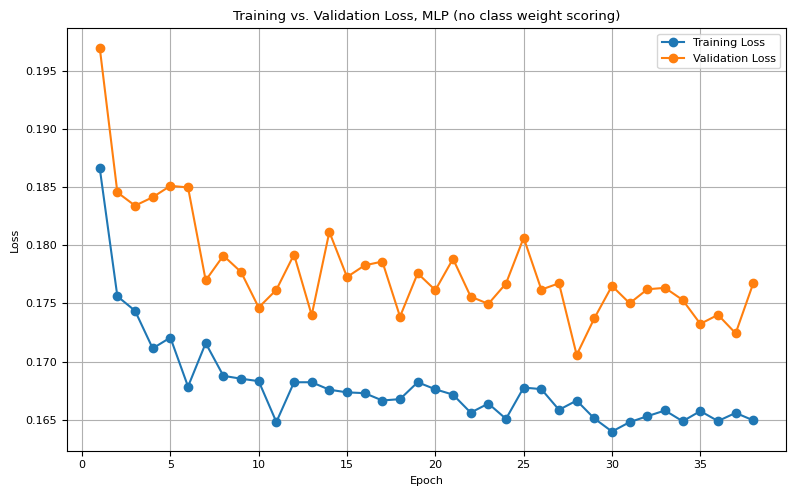

C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mayerd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP (with class weight scoring): Early Stopping at epoch 14


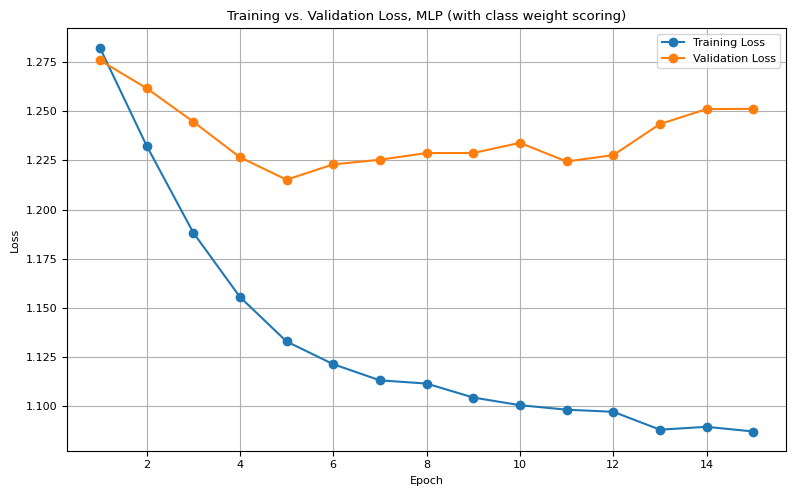

### Model Hyperparameters

,MLP (no class weight scoring),MLP (with class weight scoring)
architecture,large,small
batch_size,64,64
learning_rate,0.0005,0.0005
weight_decay,0.01,0.05
dropout,0.3,0.1
pos_weight,1.0,21.820459
epochs,120,60
early_stopping,True,True


### Model Performance on training set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,MLP (no class weight scoring),0.96,0.00,0.0,0.00,0.16,3.22,0.79,479,541
1,MLP (with class weight scoring),0.71,0.71,0.1,0.18,0.58,1.53,0.79,479,4592


### Model Performance on test set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,MLP (no class weight scoring),0.97,0.0,0.00,0.0,0.12,2.04,0.72,97,175
1,MLP (with class weight scoring),0.69,0.6,0.05,0.1,0.59,1.19,0.73,97,1481


In [519]:




# Train MLPs with pest performing hyperparameters on the overall training and validation set
best_params_models = {'MLP (no class weight scoring)': best_nn_params_no_class_weights,
               'MLP (with class weight scoring)': best_nn_params_with_class_weights}

# function to train and evaluate MLP with given parameters 
def train_and_evaluate_model(X_train_nn, y_train, X_val_nn, y_val, X_test_nn, y_test ,model_name, params, input_size, plotting=True):
    '''trans an MLP with given parameters on the overall training and validation set,
    evaluates model on the test set '''

    # Convert Data to pytorch tensors and rescale feature values based on the training set
    scaler = StandardScaler()
    X_train_tensor = torch.tensor(scaler.fit_transform(X_train_nn), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(scaler.transform(X_val_nn), dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(scaler.transform(X_test_nn), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)
    
    # Define architecture of MLP (hidden layers and neurons per layer)
    if params['architecture'] == 'small':
        model = MLP_small(input_size=input_size, dropout_rate=params['dropout'])
    elif params['architecture'] == 'medium':
        model = MLP_medium(input_size=input_size, dropout_rate=params['dropout'])
    else:
        model = MLP_large(input_size=input_size, dropout_rate=params['dropout'])

    # define loss 
    def custom_bce_loss(y_pred_prob, y_true):
            w1 = params['pos_weight']
            w0 = 1 #/ (1 + w1)
            w1 = w1 #/ (1 + w1)
            crit = nn.BCELoss(reduction='none')
            ls = crit(y_pred_prob, y_true)
            return (ls * (y_true * w1 + (1 - y_true) * w0)).mean()
    criterion = custom_bce_loss

    # Adam optimizer, with learning rate and weight decay definition
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

    # Train data loader for batching
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=params['batch_size'], shuffle=True)

    # Training
    validation_loss = []
    training_loss = []
    for epoch in range(params['epochs']):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Track training and validation loss
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)
            train_pred = model(X_train_tensor)
            train_loss = criterion(train_pred, y_train_tensor)
            training_loss.append(train_loss.item())
            validation_loss.append(val_loss.item())
            # Early stopping
            early_stopping_rounds=10
            if params['early_stopping']:
                if len(validation_loss) > early_stopping_rounds and validation_loss[-early_stopping_rounds-1] <= min(validation_loss[-early_stopping_rounds:]):
                    print(f"{model_name}: Early Stopping at epoch {epoch}")
                    break
    
    if plotting:
        # Plot training and validation loss over epochs
        epochs = range(1, len(training_loss) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_loss, label='Training Loss', marker='o')
        plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training vs. Validation Loss, {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    # Evaluation
    model.eval()    # put model in evaluation mode (no dropout used)
    with torch.no_grad():
        # Test set predictions
        y_test_pred_prob = model(X_test_tensor).squeeze()
        y_test_pred = (y_test_pred_prob > 0.5).float()

        # Train set predictions
        y_train_pred_prob = model(X_train_tensor).squeeze()
        y_train_pred = (y_train_pred_prob > 0.5).float()

    # Test set metrics
    test_metrics = {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test, y_test_pred), 2),
        'Recall': round(recall_score(y_test, y_test_pred), 2),
        'Precision': round(precision_score(y_test, y_test_pred), 2),
        'F1': round(f1_score(y_test, y_test_pred), 2),
        'Log Loss': round(log_loss(y_test, y_test_pred_prob.numpy()), 2),
        'Weighted Log Loss': round(-weighed_bce_scorer_probas(y_test_pred_prob,y_test_tensor),2),
        'ROC AUC': round(roc_auc_score(y_test, y_test_pred_prob.numpy()), 2),
        'Goals (True)': int(sum(y_test)),
        'Goals (Pred)': int(round(sum(y_test_pred_prob.numpy())))
    }

    # Train set metrics
    train_metrics = {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_train, y_train_pred), 2),
        'Recall': round(recall_score(y_train, y_train_pred), 2),
        'Precision': round(precision_score(y_train, y_train_pred), 2),
        'F1': round(f1_score(y_train, y_train_pred), 2),
        'Log Loss': round(log_loss(y_train, y_train_pred_prob.numpy()), 2),
        'Weighted Log Loss': round(-weighed_bce_scorer_probas(y_train_pred_prob,y_train_tensor),2),
        'ROC AUC': round(roc_auc_score(y_train, y_train_pred_prob.numpy()), 2),
        'Goals (True)': int(sum(y_train)),
        'Goals (Pred)': int(round(sum(y_train_pred_prob.numpy())))
    }

    return train_metrics, test_metrics, model, scaler

# train best model (with and without class-weights for scoring)
# Define overall training, validation and test set
X_train_nn = X_train.drop(columns=['MatchId'], errors='ignore')
X_test_nn = X_test.drop(columns=['MatchId'],errors='ignore')
X_val_nn = X_val.drop(columns=['MatchId'],errors='ignore')
train_results = []
test_results = []
best_clfs = []
scalers = []
input_size = len(X_train_nn.columns)
for model_name, params in best_params_models.items():
    train_result, test_result, clf, scaler = train_and_evaluate_model(
        X_train_nn=X_train_nn,
        y_train=y_train,
        X_val_nn=X_val_nn,
        y_val=y_val,
        X_test_nn=X_test_nn,
        y_test=y_test,
        model_name = model_name, 
        params = params, 
        input_size = input_size)
    train_results.append(train_result)
    test_results.append(test_result)
    best_clfs.append(clf)
    scalers.append(scaler)

mlp_clf, mlp_clf_cw = best_clfs[0], best_clfs[1] 
mlp_scaler = scalers[1]

# Display the hyperparameters of the best models
display(Markdown("### Model Hyperparameters"))
display(pd.DataFrame(best_params_models))

# Display results of best models on training and test set
df_results_train = pd.DataFrame(train_results)
display(Markdown("### Model Performance on training set"))
display(df_results_train)
df_results_test = pd.DataFrame(test_results)
display(Markdown("### Model Performance on test set"))
display(df_results_test)


#### Interpretation:
- Again, the results for MLPs are similar to those of random forest and XGBoost: Accuracy with class-weights is lower and ROC-AUC score is slightly improved compared to the model not using class weights.
- Also, measures to prevent overfitting, like early stopping, seemed to have an effect as the training log loss and the test log loss are similar in both cases. For the Model without class weights, the log loss even is lower on the test set than on the training set.

### Summary of Section 2

- The results of all three model architectures are similar, with a particular focus on ROC-AUC and accuracy
- <b>Class weights</b> slightly improved the ROC-AUC score while significantly reducing accuracy. We prioritize the (decision threshold independent) ROC-ACU score in this thesis to develop models that can rank successful corner kick actions over unsuccessful ones. Hence, we will continue with the models that resulted from using class-weights.

## 3. Global Feature Importances ##

Now we have a best model using all 32 correlation-filtered features. To reduce model complexity and to ease explainability of the final models, we select 15 overall top performing features.
As the models using class weights perform better on the ROC AUC score, we continue with the best models using class-weights.
To select 15 features, 
1. Calculate global feature importance (sum of impurity reduction for tree based models / absolute SHAP values on the test set for MLP, scaled so that all feature importances sum up to 1) for each architecture.
2. Calculate average importance over all three architectures per feature, sort them by the average.
3. From the 20 features with the highest average, manually select 15 features in consultation with match analysts at TSG Hoffenheim.

First, calculate global Feature importances

In [311]:
###############################
###############################
## Global Feature Importance ##
###############################
###############################

# Tree based models Random Forest and XGBoost: use built in scaled impurity reduction per feature
feature_names = X_test.columns
ft_importance_rf = rf_clf_cw.feature_importances_
ft_importance_xgb = xgb_clf_cw.feature_importances_


# MLP: Use summed absolute SHAP values on the test set samples
# Need to transform between numpy and torch data formats
def model_wrapper(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)  # Convert NumPy array to tensor
    with torch.no_grad():
        return mlp_clf_cw(x_tensor).numpy()  # Convert output back to NumPy
# Convert input tensors to NumPy (SHAP requires NumPy arrays)
X_test_tensor = torch.tensor(mlp_scaler.transform(X_test_nn), dtype=torch.float32)
X_test_np = X_test_tensor.numpy()
# Adjust column names
explainer = shap.Explainer(model_wrapper, X_test_np, feature_names=feature_names)
# Compute SHAP values
shap_values = explainer(X_test_np)
# SHAP values are in shap_values.values with shape (n_samples, n_features)
shap_array = np.abs(shap_values.values)  # Take absolute values
# Sum over samples (axis=0) to get total importance per feature
shap_importance = shap_array.sum(axis=0)
# Normalize by the total sum to get values adding up to 1
ft_importance_mlp = shap_importance / shap_importance.sum()
# Put importances per model in a dataframe and display them
dict_model_names = {
    "Random Forest": ft_importance_rf,
    "XGBoost": ft_importance_xgb,
    "MLP": ft_importance_mlp
}
dict_ft_imps_all = {}
for name in dict_model_names.keys():
    imps = dict_model_names[name]
    dict_ft_imps = {feature_names[i]: imps[i] for i in range(len(feature_names))}
    dict_ft_imps_all[name] = dict_ft_imps


PermutationExplainer explainer: 3523it [00:43, 60.40it/s]                          


Calculate average importance over all three model architectures and display them

In [252]:
# Put importances in a dataframe
df_ft_importances = pd.DataFrame(dict_ft_imps_all)
# Compute average 
df_ft_importances["Average"] = df_ft_importances[list(dict_model_names.keys())].mean(axis=1)
# For displaying: Multiply all importances by 100 and round to 1 decimal place
df_ft_importances = df_ft_importances.map(lambda x: round(x * 100, 1))
# Sort by average importance (descending)
df_ft_importances = df_ft_importances.sort_values(by="Average", ascending=False)
# Insert position as the first column
df_ft_importances.insert(0, "Position", [f"{i+1}." for i in range(len(df_ft_importances))])
# Rename the index
df_ft_importances.index.name = "Feature Name"
display(Markdown('### Global Feature Importances (in %) over different model architectures'))
display(df_ft_importances)

### Global Feature Importances (in %) over different model architectures

,Position,Random Forest,XGBoost,MLP,Average
Feature Name,,,,,
sp_position_distance_to_goal,1.,20.8,11.4,18.9,17.1
sp_position_vertical_zone,2.,6.2,6.1,9.0,7.1
sp_first_ball_action_ball_z_max,3.,7.1,4.6,8.3,6.7
sp_heights_shot_zone_defense_mean,4.,7.4,5.5,6.5,6.4
sp_heights_shot_zone_offense_count,5.,3.6,5.5,8.9,6.0
sp_delivery_velocity,6.,4.8,3.0,4.3,4.0
sp_space_control_in_box_offense,7.,3.5,3.9,4.0,3.8
sp_delivery_distance,8.,6.0,4.1,0.7,3.6
sp_position_angle_to_goal,9.,3.7,3.2,2.9,3.3


On the basis of this analysis, the following 15 features have been selected in consultation with match analysts at TSG Hoffenheim.

In [ ]:
top_15_features = ['sp_position_distance_to_goal',              # Distance to goal of the ball for the current action
                    'sp_position_vertical_zone',                # Vertical pitch zone of the ball for the current action
                    'sp_first_ball_action_ball_z_max',          # Maximum height of the ball over ground during the first kick of the respective possession 
                    'sp_heights_shot_zone_defense_mean',        # Average height of defending players in the golden zone at the time of the current action
                    'sp_heights_shot_zone_offense_count',       # Number of attacking players in the golden zone at the time of the current action
                    'sp_delivery_velocity',                     # Average velocity of the ball during the first kick of the respective possession
                    'sp_space_control_in_box_offense',          # Space control metric in the penalty are at the time of the current action
                    'sp_delivery_distance',                     # Distance covered by the ball during the first kick of the respective possession
                    'sp_position_angle_to_goal',                # Angle to goal of the ball at the time of the current action
                    'sp_delivery_end_position_angle_to_goal',   # Angle to goal of the ball after the first kick of the respective possession
                    'sp_delivery_end_position_distance_to_goal',# Distance to goal of the ball after the first kick of the respective possession
                    'sp_defensive_pressure_shot_zone_mean',     # Average defensive pressure metric on attacking players in the golden zone at the time of the current action
                    'sp_avg_speeds_shot_zone_offense_mean',     # Average moving speed of attacking players in the golden zone at the time of the current action
                    'sp_duration',                              # Duration of the current set piece possession up to the time of the current action
                    'sp_heights_shot_zone_offense_mean']        # Average height of attacking players in the golden zone at the time of the current action


## 4. Model Training with reduced Features ##

with the selected top 15 features, another hyperparameter search is performed for Random Forest, XGBoost and MLP.
Based on the results of models on all features, we from now on only consider models using class weight during scoring.

In [438]:
# Define reduced Training sets only containing top 15 features
X_train_top15 = X_train[["MatchId"] + top_15_features]
X_val_top15 = X_val[["MatchId"] + top_15_features]
X_train_cv_top15 = X_train_cv[["MatchId"] + top_15_features]
X_test_top15 = X_test[top_15_features]

#
best_rf_params_top15 = randomized_search_cv_random_forrest(
    X_train=X_train_cv_top15,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer,
    n_folds=5,
    n_iter=100,
    random_state=random_state
)

best_xgb_params_top15 = randomized_search_cv_xgboost(
    X_train=X_train_cv_top15,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer,
    n_folds=5,
    n_iter=100,
    random_state=random_state
)

best_nn_params_top15 = randomized_search_cv_nn(
    X_train=X_train_cv_top15,
    y_train=y_train_cv,
    scorer=weighed_bce_scorer_probas,
    n_folds=5,
    n_iter=40,
    random_state=random_state
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Average score of best parameters over 5 folds:  -1.18050079594461
Standard deviation of score of best parameters over 5 folds:  0.09047050035620532
Training XGBoost with randomized search and cross-validation
Number of parameter combinations:  100
Number of folds:  5
Total number of models:  500


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2570392352.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1921
Standard Deviation of best combination over splits:  0.0533
Training MLP with randomized search and cross-validation
Number of parameter combinations:  40
Number of folds:  5
Total number of models:  200


C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\3155848205.py:257: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rs_results = pd.concat([rs_results, pd.DataFrame([row])], ignore_index=True)


Best Score:  -1.1674
Standard Deviation of best combination over splits:  0.04845


Train and evaluate the best model for each architecture

In [520]:
X_train_top15 = X_train_top15[top_15_features]
X_val_top15 = X_val_top15[top_15_features]
X_train_cv_top15 = X_train_cv_top15[top_15_features]
X_test_top15 = X_test_top15[top_15_features]

## Train Best Random forest with top 15 features
rf_clf_top15 = RandomForestClassifier(**best_rf_params_top15, random_state=random_state)
rf_clf_top15.fit(X_train_cv_top15, y_train_cv)

## Train best XGBoost with top 15 Features
xgb_clf_top15 = xgb.XGBClassifier(**best_xgb_params_top15)
xgb_clf_top15.fit(
                X_train_top15, y_train,
                eval_set=[(X_val_top15, y_val)],
                verbose=False
            )

## Train best MLP with top 15 Features

train_result, test_result, mlp_clf_top15, mlp_scaler_top15 = train_and_evaluate_model(
        X_train_nn=X_train_top15,
        y_train=y_train,
        X_val_nn=X_val_top15,
        y_val=y_val,
        X_test_nn=X_test_top15,
        y_test=y_test,
        model_name = "MLP", 
        params = best_nn_params_top15, 
        input_size = len(X_test_top15.columns),
        plotting=False)

## Display best models parameters
display(Markdown("### Model Hyperparameters using top 15 features and class weights"))
display(pd.DataFrame({"Random Forest": best_rf_params_top15}))
display(pd.DataFrame({"XGBoost": best_xgb_params_top15}))
display(pd.DataFrame({"MLP": best_nn_params_top15}))
## Evaluate all three models on training and test set
display(Markdown('## Model Performance using Class weights and the Top 15 Features'))
evaluate_models_on_trainingset({"RandomForest": rf_clf_top15, "XGBoost":xgb_clf_top15}, top_15_features, add_info={"MLP": train_result})
evaluate_models_on_testset({"RandomForest": rf_clf_top15, "XGBoost":xgb_clf_top15}, top_15_features, add_info={"MLP": test_result})


MLP: Early Stopping at epoch 30


### Model Hyperparameters using top 15 features and class weights

,Random Forest
bootstrap,True
class_weight,balanced
criterion,entropy
max_depth,6
max_features,sqrt
max_samples,0.7
min_samples_leaf,2
min_samples_split,3
n_estimators,186


,XGBoost
objective,binary:logistic
eval_metric,logloss
scale_pos_weight,21.820459
max_depth,3
n_estimators,180
eta,0.01
gamma,0.2
subsample,0.7
colsample_bytree,0.3
lambda,0.0


,MLP
architecture,small
batch_size,64
learning_rate,0.0005
weight_decay,0.05
dropout,0.1
pos_weight,21.820459
epochs,90
early_stopping,True


## Model Performance using Class weights and the Top 15 Features

### Evaluation Results on Training Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,RandomForest,0.84,0.61,0.15,0.24,0.50,1.01,0.85,479,4149
1,XGBoost,0.73,0.77,0.12,0.20,0.57,1.10,0.83,479,4701
2,MLP,0.71,0.67,0.10,0.17,0.61,1.48,0.77,479,4814


### Evaluation Results on Test Set

,Model,Accuracy,Recall,Precision,F1,Log Loss,Weighted Log Loss,ROC AUC,Goals (True),Goals (Pred)
0,RandomForest,0.84,0.44,0.08,0.13,0.51,0.89,0.75,97,1321
1,XGBoost,0.71,0.57,0.05,0.10,0.58,0.94,0.74,97,1506
2,MLP,0.70,0.58,0.05,0.10,0.62,1.16,0.73,97,1546


#### Interpretation

- Random Forest shows the best performance, both in threshold independent metrics like ROC-AUC / log-loss and threshold dependent accuracy.
- All three models overestimate goal probabilities, as the sum of predicted goals is much larger than the actual goals in the test set.
- Accuracy for XGBoost and MLP of 71 and 72 % is quite low.
- Generalization is good: log loss and accuracy on training and test set is almost identical for all three architectures.
- The results are also very similar to the results of models using all 32 features.

## 5. Model Interpretation ##

### Use SHAP Values on the Test set ###
Using the best models on the top 15 features, the shapley values are inspected on a single sample level for the test set.

First, produce a <i>summary plot</i> of the SHAP values on the test set for each model architecture. The summary plot shows per feature for each sample in the test set whether the respective feature value was relatively low or high (using colors) and what impact the feature value had on the model output. A positive value means that the feature value lead the model towards predicting a goal, a negative value means that the it lead the model towards predicting no goal.

## Random Forest SHAP Summary Plot

C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2482647650.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test_top15, show=False)


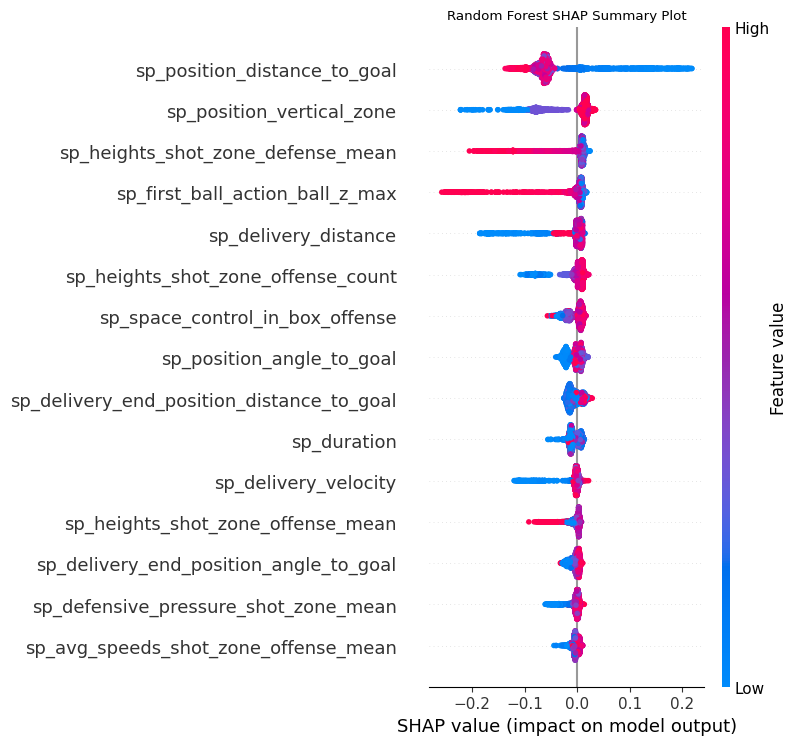

## XGBoost SHAP Summary Plot

C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2482647650.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_top15, show=False)


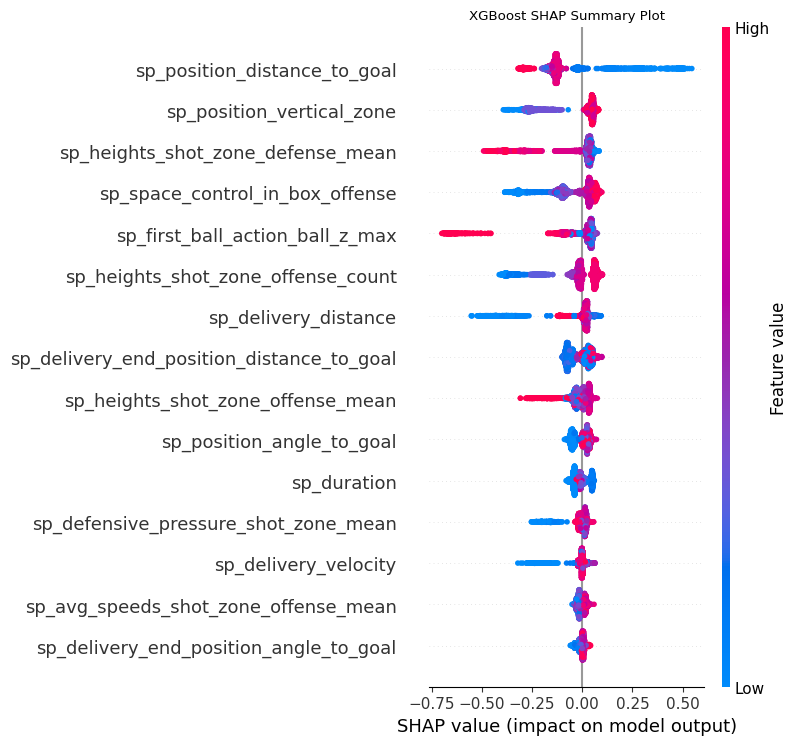

PermutationExplainer explainer: 3523it [01:04, 47.15it/s]                          


## MLP SHAP Summary Plot

C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2482647650.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_mlp, X_test_top15, show=False)


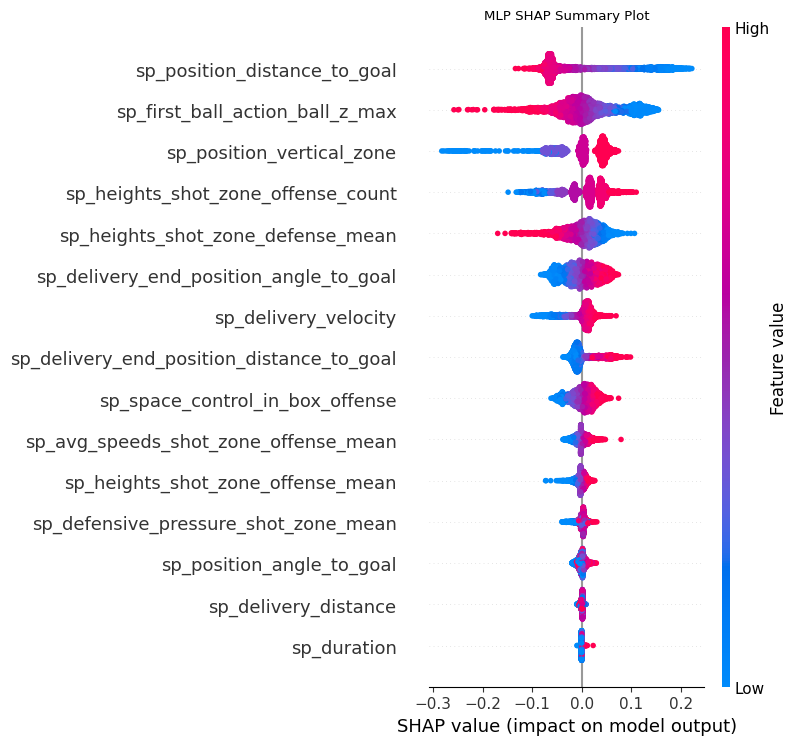

In [441]:
### Printe Klassischen SHAP Plot, Shap Plot per feature und einen Force plot als beispiel mit den top 15 modellen
# ----------- Random Forest SHAP -----------
# print(X_test_top15.shape)
# print(X_test_top15.columns)

explainer_rf = shap.TreeExplainer(rf_clf_top15)
# take shap values on the predicitons of the positive class
shap_values_rf = explainer_rf(X_test_top15)[:,:,1]

display(Markdown("## Random Forest SHAP Summary Plot"))
shap.summary_plot(shap_values_rf, X_test_top15, show=False)
plt.title("Random Forest SHAP Summary Plot")
plt.tight_layout()
plt.show()

# ----------- XGBoost SHAP -----------
explainer_xgb = shap.TreeExplainer(xgb_clf_top15)
shap_values_xgb = explainer_xgb(X_test_top15)
# take shap values on the predicitons of the positive class

display(Markdown("## XGBoost SHAP Summary Plot"))
shap.summary_plot(shap_values_xgb, X_test_top15, show=False)
plt.title("XGBoost SHAP Summary Plot")
plt.tight_layout()
plt.show()



# ----------- MLP SHAP -----------
def model_wrapper_top15(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)  # Convert NumPy array to tensor
    with torch.no_grad():
        return mlp_clf_top15(x_tensor).numpy()  # Convert output back to NumPy
# Convert input tensors to NumPy (SHAP requires NumPy arrays)
X_test_top_15_tensor = torch.tensor(mlp_scaler_top15.transform(X_test_top15), dtype=torch.float32)
X_test_top15_np = X_test_top_15_tensor.numpy()
# Adjust column names
explainer_mlp = shap.Explainer(model_wrapper_top15, X_test_top15_np, feature_names=top_15_features)
# Compute SHAP values
shap_values_mlp = explainer_mlp(X_test_top15_np)
# Display summary plot
display(Markdown("## MLP SHAP Summary Plot"))
shap.summary_plot(shap_values_mlp, X_test_top15, show=False)
plt.title("MLP SHAP Summary Plot")
plt.tight_layout()
plt.show()




#### Interpretation (for Random Forest, as it is the best performing model) for selected features

- The features $\verb|sp_position_distance_to_goal|$ and $\verb|sp_position_vertical_zone|$ (high value = closer to the goal line) show that the model uses proximity to the goal as a large predictor; the closer an action is to the goal, the more likely the model is to predict a subsequent goal. This is in agreement with e.g. expected goal models for open play.
- The third feature - average heights of defenders in the golden zone - shows that tall defenders in the dangerous golden zone prevent the model from predicting goals, this is in agreement with the assumption that tall defenders are more able to win aerial duals and clear high balls out of the dangerous zone.
- The fourth and fith feature - maximum height and distance covered by the ball during the first kick of the current corner possession - shows that a very high delivery as well as short pass deliveries lead the model to not predict a successful outcome of the corner.


#### For a deeper insight, plot the SHAP values of the test set against the feature values for each feature. Also fit a polynomial (red dashed line) for each feature to reveal feature values that make a goal after corner kick particularly likely. To fit the polynomial, outliers of the feature values are removed.

C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2247065554.py:21: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(testdata, svs, 5)


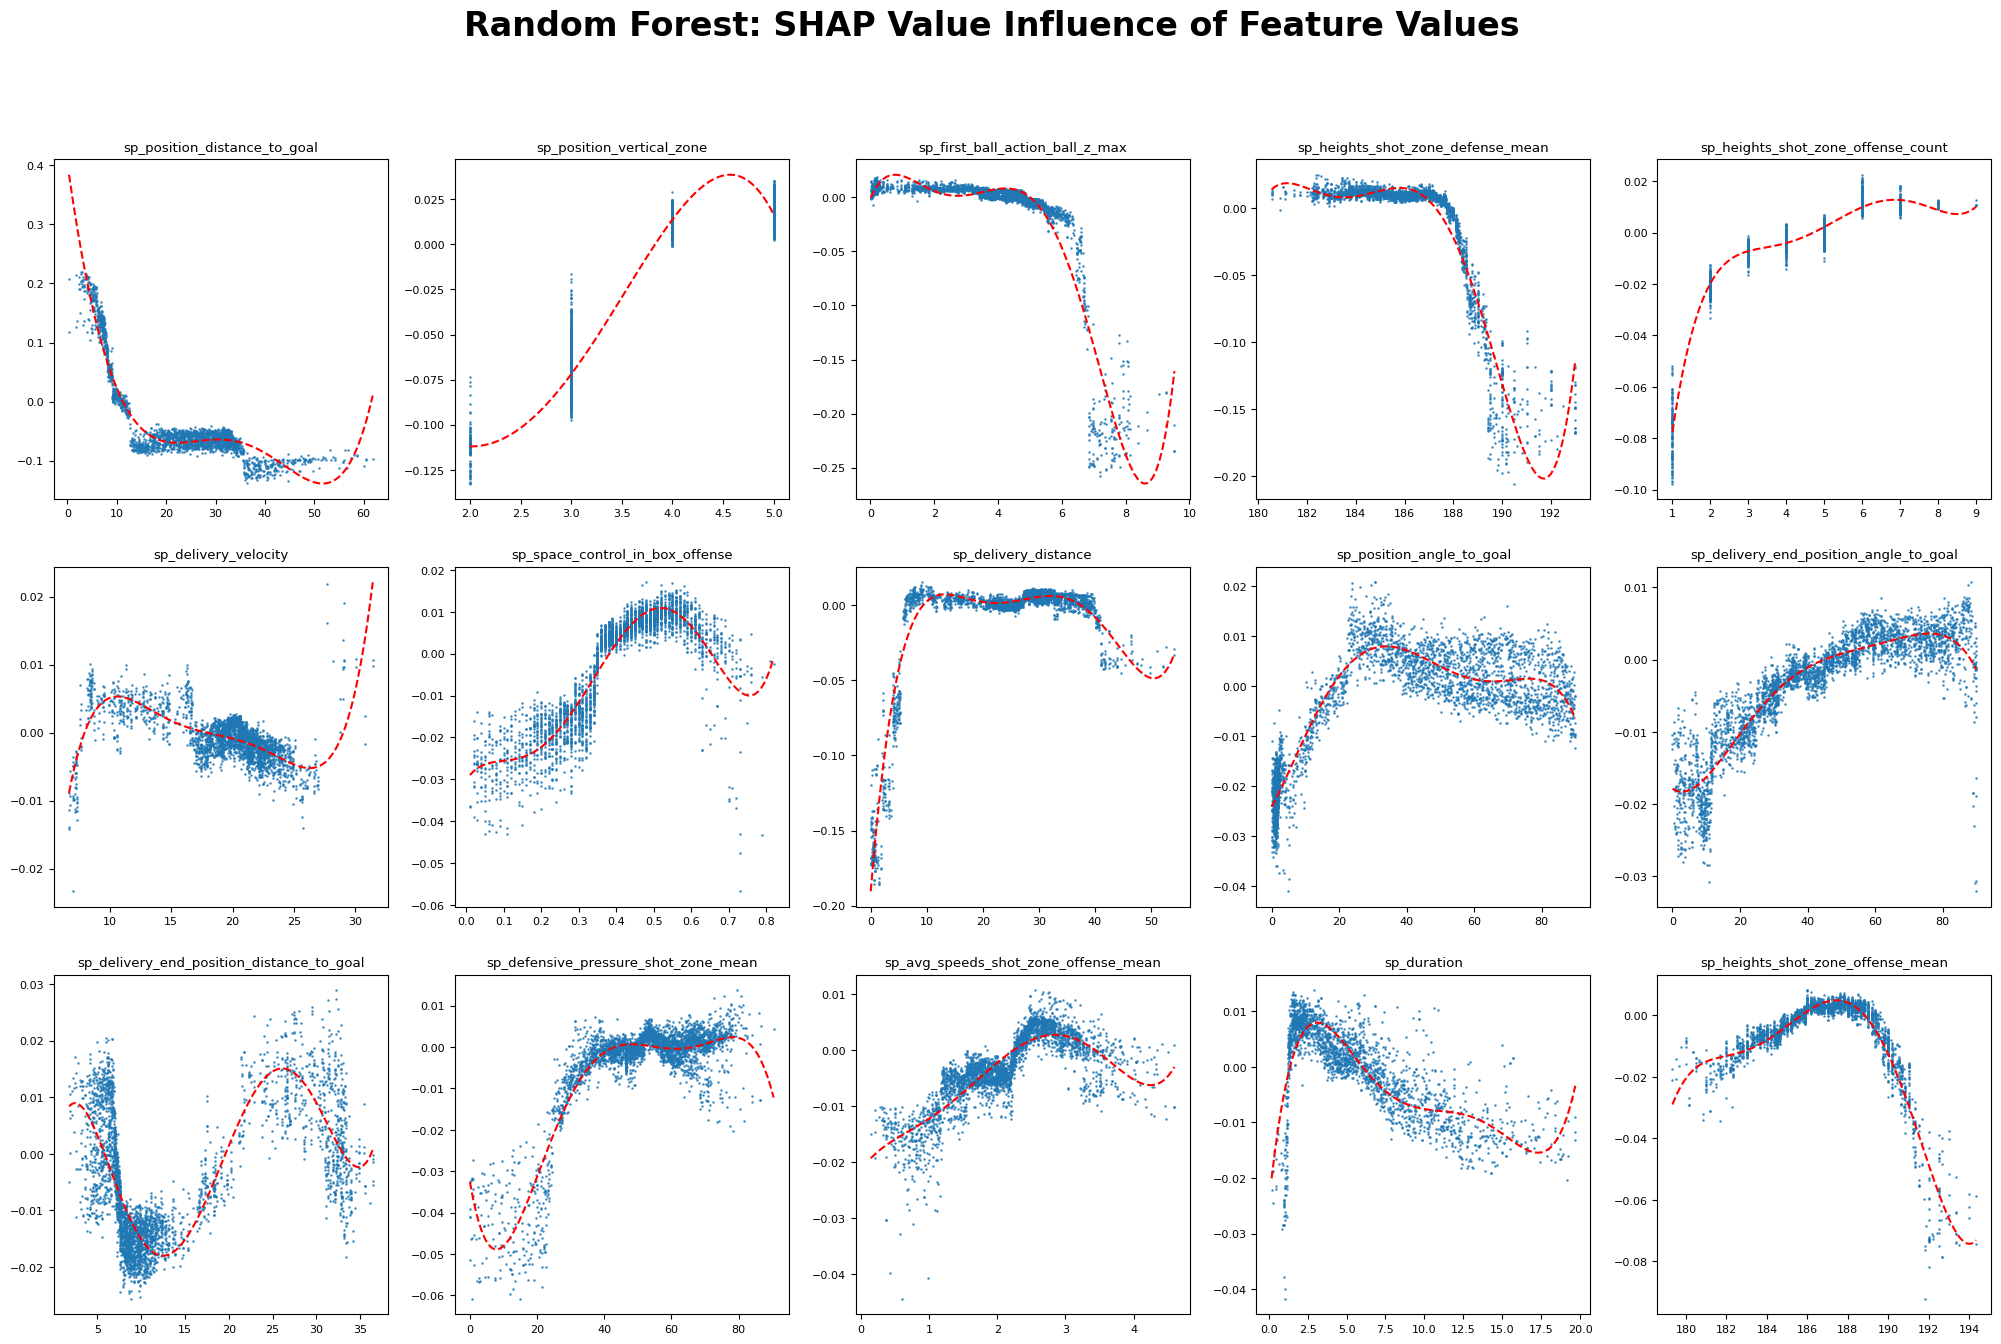

C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2247065554.py:21: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(testdata, svs, 5)


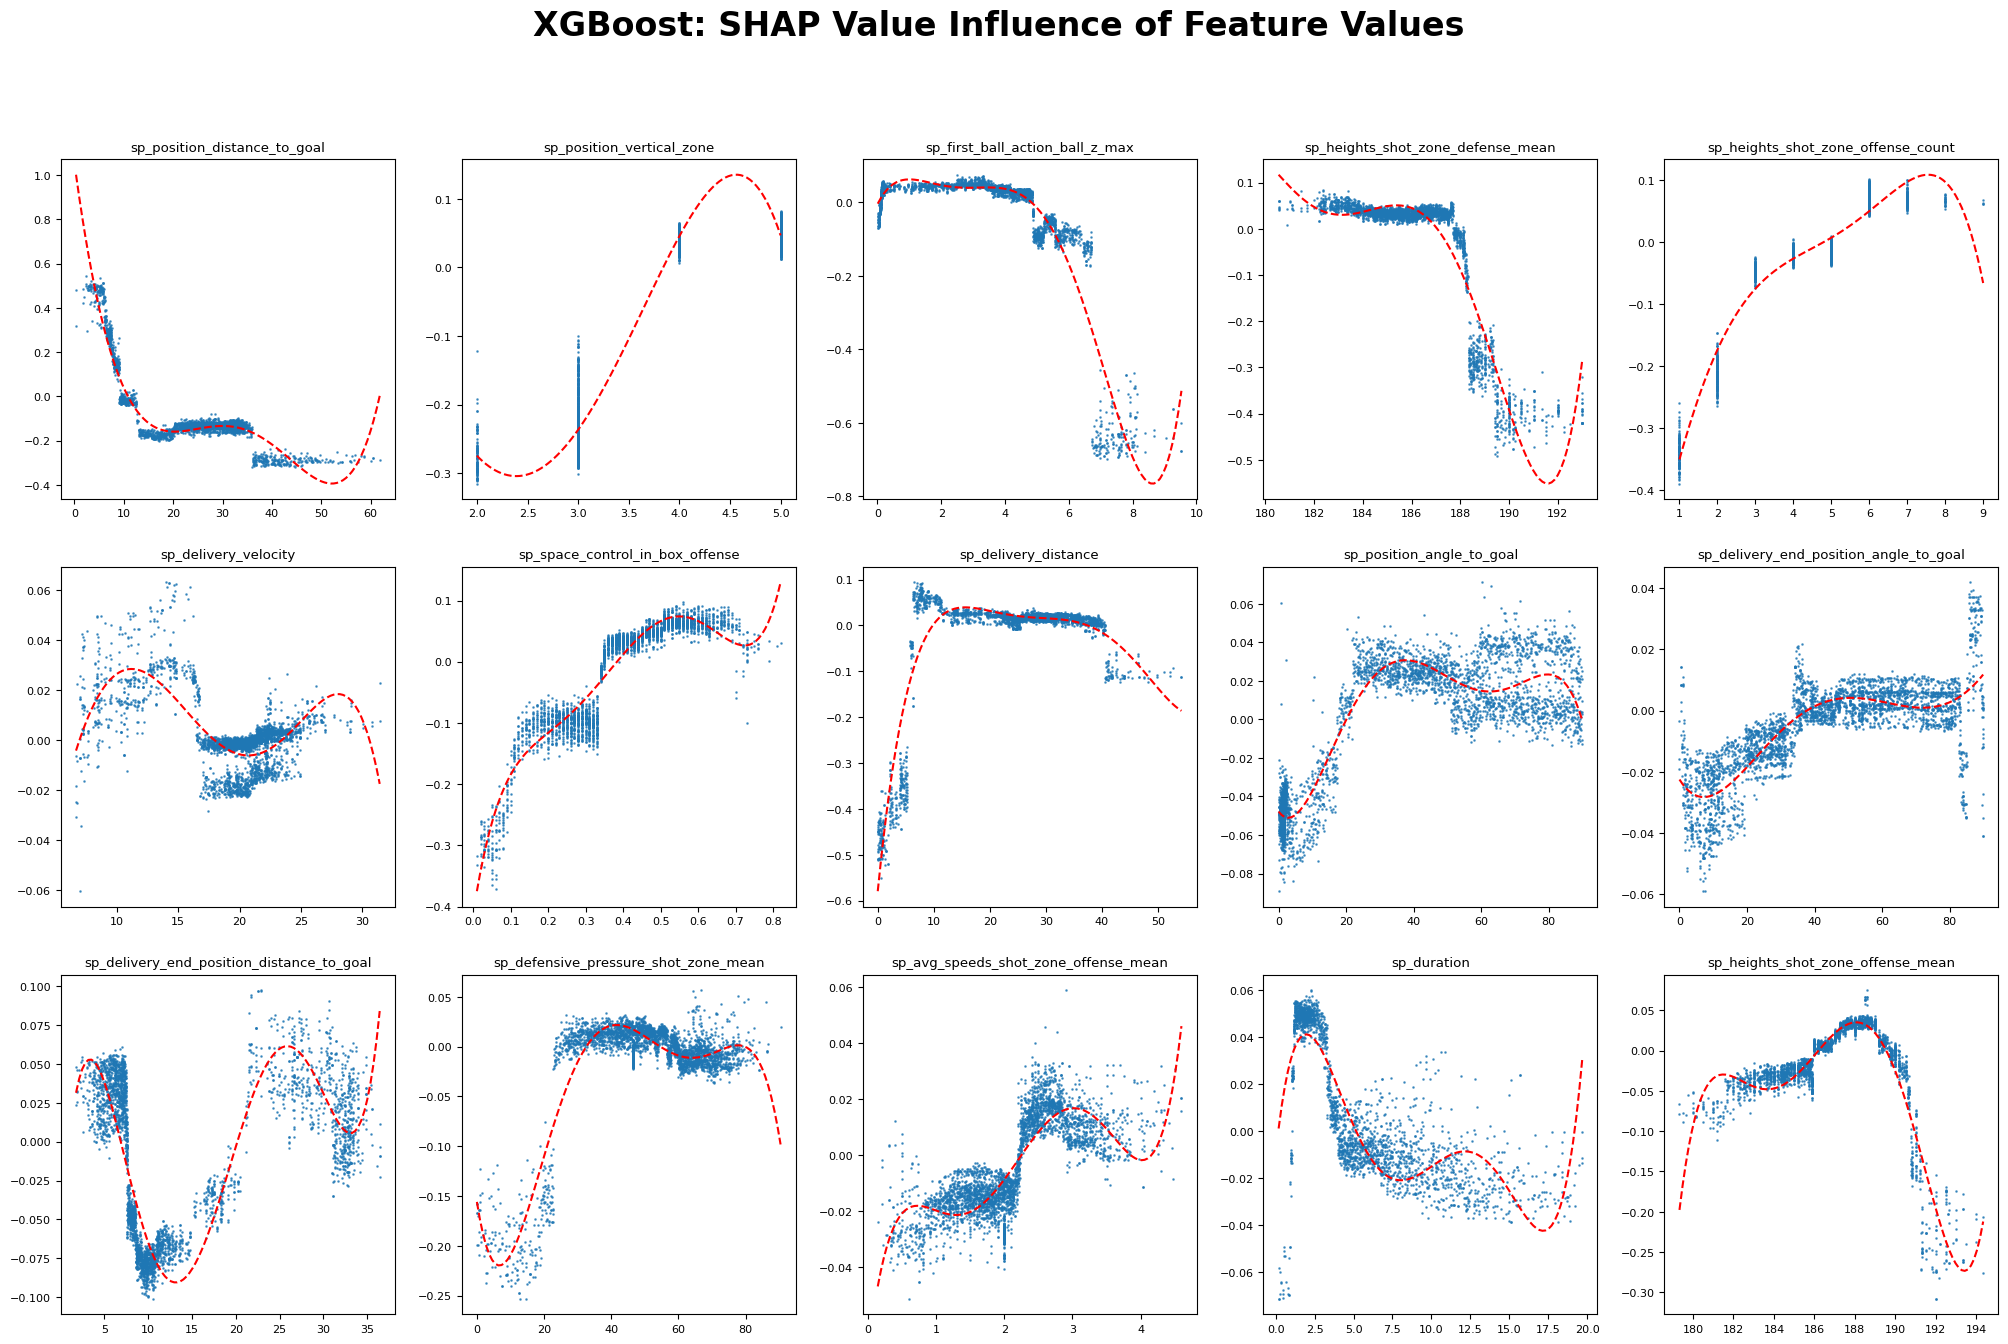

C:\Users\mayerd\AppData\Local\Temp\ipykernel_2224\2247065554.py:21: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(testdata, svs, 5)


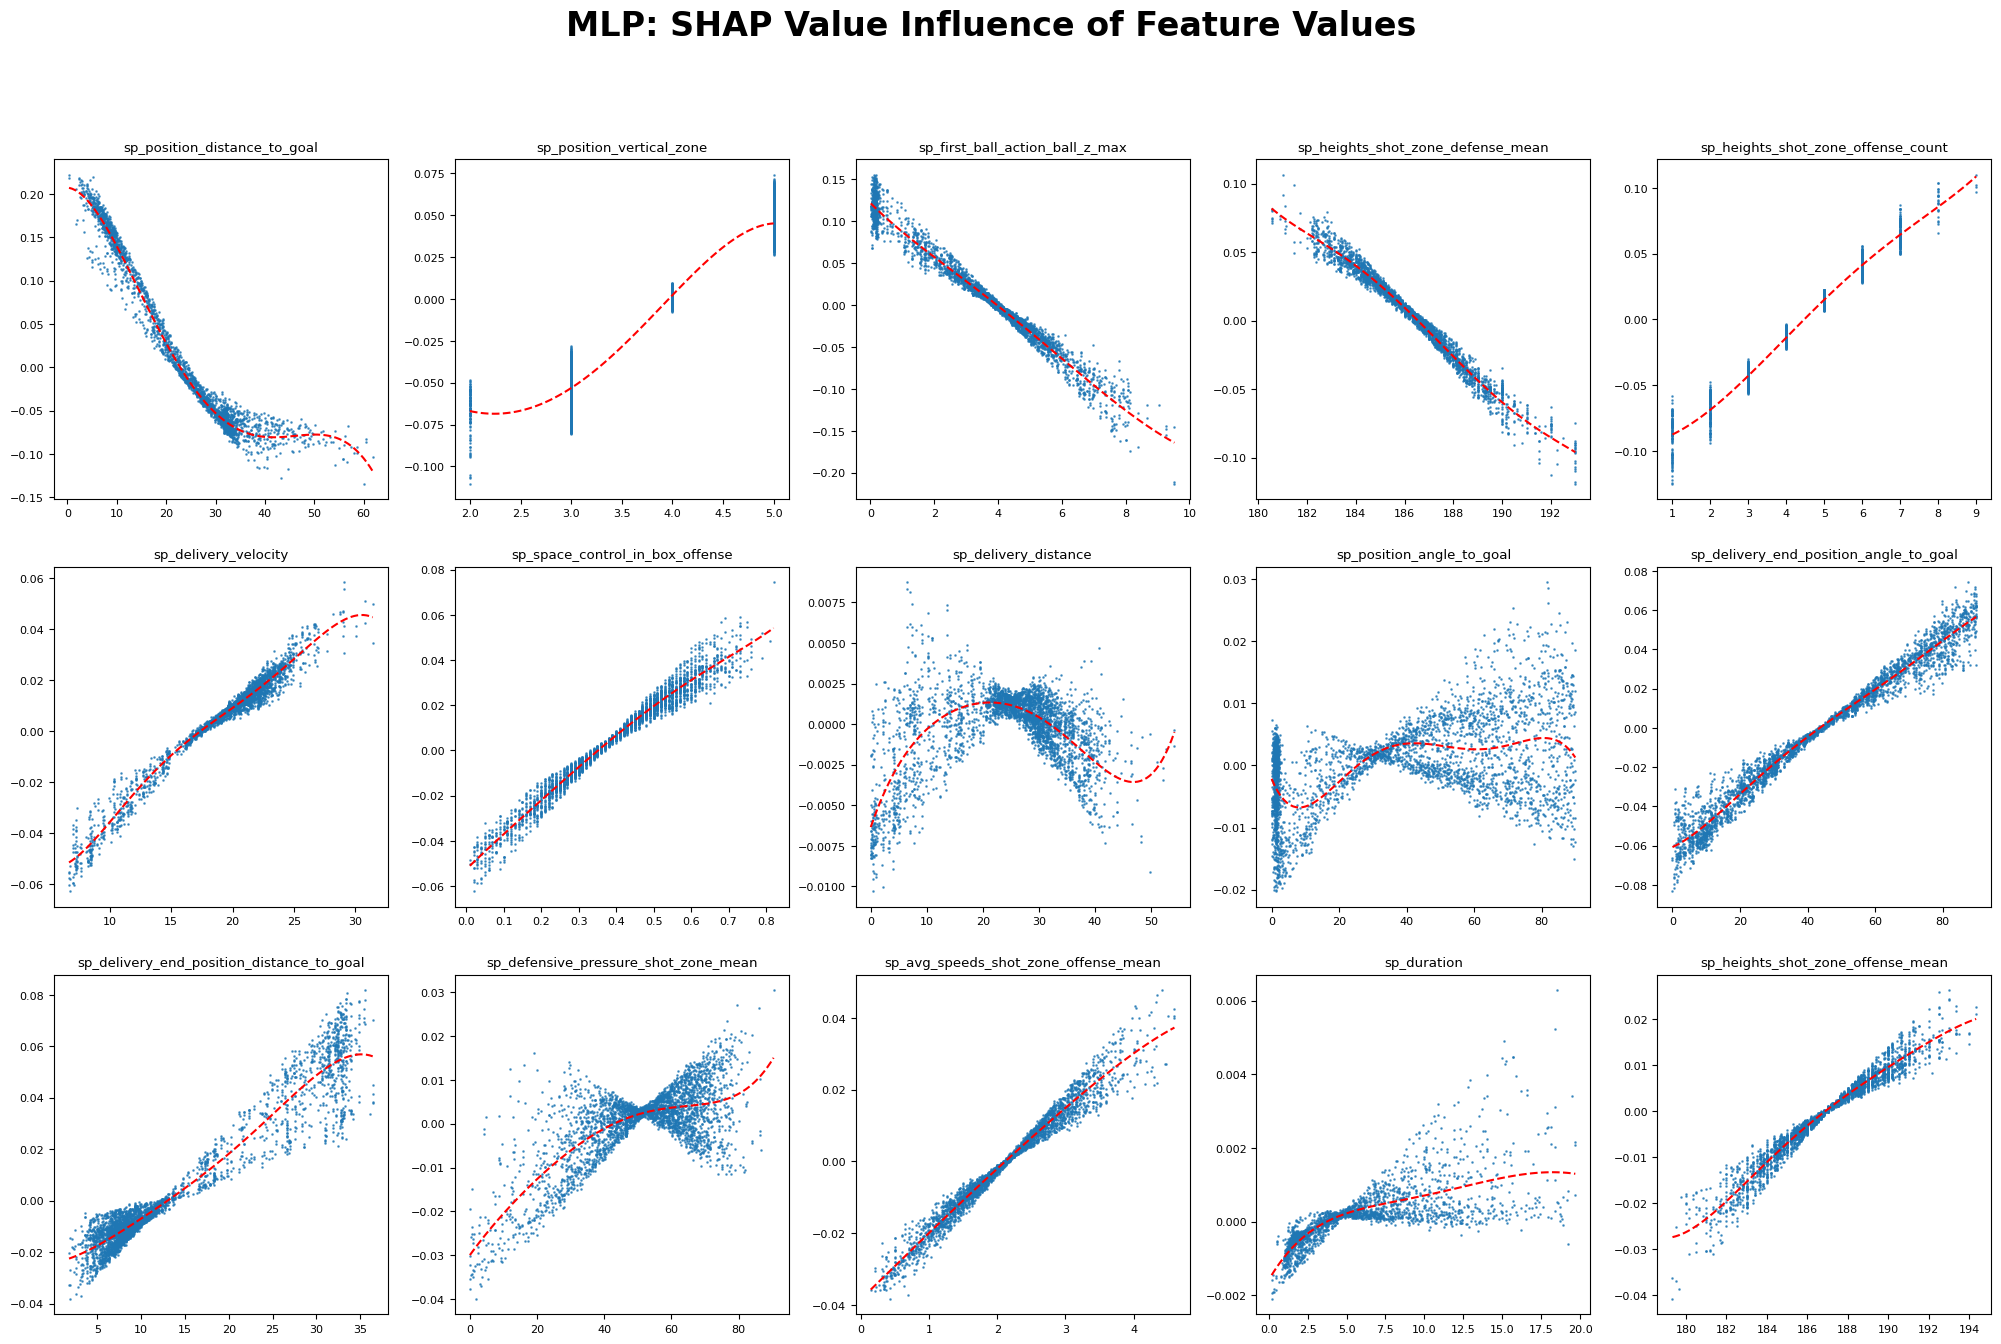

In [442]:
def shap_plot_per_feature(fts, shap_values,X_test,title="Influence of Feature Values on SHAP Values"):

    fig, ax = plt.subplots(3, 5, figsize=(25, 15))

    for i in range(len(fts)):
        ft = fts[i] 
        svs = shap_values.values[:,i]
        testdata = X_test[fts[i]].to_numpy()

        # remove outliers from testdata
        q1 = np.percentile(testdata, 25)
        q3 = np.percentile(testdata, 75)
        iqr = q3 - q1
        lower_bound = max(q1 - 2 * iqr,0)
        upper_bound = q3 + 2 * iqr
        svs = svs[(testdata > lower_bound) & (testdata < upper_bound)]
        testdata = testdata[(testdata > lower_bound) & (testdata < upper_bound)]

        # polynomial fit (degree: 5)
        x_s = np.linspace(min(testdata), max(testdata), 100)
        z = np.polyfit(testdata, svs, 5)
        p = np.poly1d(z)
        ax[i//5, i%5].plot(x_s, p(x_s), "r--")
        ax[i // 5, i % 5].scatter(testdata, svs, alpha=0.7, s=0.8)
        ax[i // 5, i % 5].set_title(fts[i])
        fig.suptitle(title, fontsize=24, fontweight='bold')
    

    plt.show()

shap_plot_per_feature(top_15_features,shap_values_rf,X_test_top15,"Random Forest: SHAP Value Influence of Feature Values")
shap_plot_per_feature(top_15_features,shap_values_xgb,X_test_top15,"XGBoost: SHAP Value Influence of Feature Values")
shap_plot_per_feature(top_15_features,shap_values_mlp,X_test_top15,"MLP: SHAP Value Influence of Feature Values")

#### Interpretation:

The above plots are reveiling tendencies about how each model uses each feature to make a prediction. We will focus on the best performing random forest model, but note that xgboost shows very similar tendencies to the random forest model. When inspecting the plots for the MLP, they show that the resulting shap values are almost linear in many features, in contrast to the tree based models. Another neural network architecture could be chosen in the future to better capture the assumed nonlinear processes that are underlying to corner kick.

Interpretation of the plot for the random forest model:
- As expected, the predicted goal probability for an action during a corner kick is mostly influenced by the proximity of the action to the attacked goal: The closer the action is to goal (low value for $\verb|sp_position_distance_to_goal|$, high value for  $\verb|sp_position_vertical_zone|$), the higher the shap values, i.e. the more the model has a tendency to predict a goal.
- The feature  $\verb|sp_first_ball_action_z_max|$ captures the maximum height (in m) of the ball over ground for the first kick of the corner possession. At around 7 meters, there is a sharp drop in SHAP values, meaning extremely high first deliveries most likely do not result in goals, according to the model. 
- A similar sudden drop can be seen for the feature $\verb|sp_heights_shot_zone_defense_mean|$, which covers the average body height (in cm) of defenders in the penalty area at the moment of the given action. This drop can be interpreted in the way that if the defending team is occupying the penalty area with tall players, they are more likely to win aerial duels against attackers and clear the ball out of the dangerous zone.
- $\verb|sp_heights_shot_zone_offense_count|$ captures the number of attackers present in the <i>golden zone</i> and the model clearly evaluates an action as more dangerous the more attackers are present in that area.
- $\verb|sp_delivery_velocity|$ and $\verb|sp_delivery_distance|$ capture the average velocity (in m/s) and distance (in m) of the initial execution of the corner kick possession. The model attributes lower goal probability if the distance is very short (short pass close to the corner, <10m, instead of a cross into the dangerous area) or very long (around 50 meters, which is much further away from the corner than the goal center). For the velocity, there seems to be a sweet spot around 10-15 m/s for the initial kick. Also, extremely hard kicked corners (<25 m/s) have large positive shap values.
- $\verb|sp_space_control_in_box_offense|$ captures how much area (in %) the attackers control in the penalty area at the moment of each action (calculated using voronoi diagrams). As expected, SHAP values increase on average the more space the attacking team controls in the penalty area, but only up to a space control of 60 %. From then on, increasing space control does not lead to a higher predicted SHAP value. 
- $\verb|sp_delivery_end_position_distance_to_goal|$ and $\verb|sp_delivery_end_position_angle_to_goal|$ capture the distance (in m) and angle (in °, 0° is on the goal line, 90° is central in front of the goal) to the goal center at the moment the initial execution kick is first touched by another player (the end position of the <i>delivery</i>). Here we see that the model attributes high values if the initial kick is played either very close to goal (<10m) or further away from the goal (~25m). The model also rates a higher angle - so a more central position of the delivery end position - as beneficial for goal scoring probability. This is in agreement with the most used tactic for corner kicks in soccer: deliver the ball directly into the golden zone, close and central in front of the goal, for another attacker to convert it.
- $\verb|sp_defensive_pressure_shot_zone_mean|$ captures the average defensive pressure metric over the attackers that are in the golden zone at the moment of each action. Contrary to the expected behaviour, the model attributes low goal scoring probabilities if the defensive pressure is lower, meaning that the attackers have on average less pressure by defenders and can behave undisturbed. This could be explained by the fact that attackers are covered less by defenders if the ball is far away from them and has a low chance to be played to them, which also means that there is no immediate threat to the goal and therefore a lower probability to score a goal in the following actions. This illustrates that looking at a single feature value is not sufficient to explain the success / lack of success for a given action.
- $\verb|sp_avg_speeds_shot_zone_mean|$ covers the average speeds of attacking players in the golden zone over the 0.5 seconds prior to each action. The model attributes the highest SHAP values if the average speeds are around 3 m/s, up to which point increasing speeds, i.e. a more dynamic offense, increases predicted goal probability by the model.
- $\verb|sp_duration|$ captures how long after the initial execution of the corner kick possession the action takes place. Actions within the first few seconds after execution (2-5 seconds) have an increased predicted goal probability, so the model values actions short after execution as the most dangerous ones.
- $\verb|sp_heights_shot_zone_offense_mean|$ captures the average body height (in cm) of the attackers in the golden zone at the moment of each action. Here we can observe another unexpected behaviour by the model. We assume that larger body height allows attackers to easier win aerial duels and therefore convert chances into goals. The model agrees, but only up to a body height of around 190 cm. For larger average heights, the model attributes a lower goal probability. A possible explaination for this is that these large average heights can only occur if there are just few, very tall players in the golden zone, meaning that there is low space coverage in the dangerous area by the attacking team and therefore little chance of success.

#### Finally, we analyze a successful corner by TSG Hoffenheim, To do that, we create a <i>Force Plot</i> for four actions during the given corner kick possession. The force plot shows the predicted goal probability at each given action and how each feature value either contributed to an increased (blue) or decreased (red) predicted goal probability.

A video of the scene can be seen here: https://www.youtube.com/watch?v=J7OWyaeFVao&t=93s

The corner kick was cut off in the video as the goal happens over 20 seconds after initial execution, but the 4 actions by Hoffenheim that were within the 10 second-success criterion can be seen:

1. Pass by Kevin Vogt to Ihlas Bebou (way outside the penalty area)
2. Cross into the box by Ihlas Bebou (gets deflected by a defender)
3. Marius Bülter receives the ball and directly plays a high pass over to Wout Weghorst
4. Weghorst can head the ball into goal from close distance without any defenders disturbing him.

In [434]:
# Find succesful samples of Hoffenheim corners in the test set
filtered_data = events_processed[(events_processed['epv_success'] == 1)&(events_processed['possesion_chain_team']=="TSG Hoffenheim")]
common_indices = X_test_top15.index.intersection(filtered_data.index)
filtered_data = filtered_data[filtered_data.index.isin(common_indices)]
row_numbers = [X_test_top15.index.get_loc(idx) for idx in common_indices]

# display(filtered_data)

# possession_chain = 39
# MatchId = 'DFL-MAT-J03YGI'

# display(events_processed[(events_processed["MatchId"]==MatchId) & (events_processed["possesion_chain"]==possession_chain)] )

descriptions = [
    "1. Pass by Kevin Vogt to Ihlas Bebou (way outside the penalty area, defense is organized)",
    "2. Cross into the penalty area by Ihlas Bebou (gets deflected by a defender and to the other horizontal side of the pitch, creates disorder in the defense)",
    "3. Marius Bülter receives the ball and directly plays a high pass over to Wout Weghorst, changing horizontal side of the pitch again and further disorienting the defense",
    "4. Weghorst can head the ball into goal from close distance without any defenders disturbing him."
]

# The resulting samples all belong to the same corner kick possession, 
# plot SHAP force plot for each sample in sequence
shap.initjs()
for i, sample_idx in enumerate(row_numbers):
    
    sample = X_test_top15.iloc[sample_idx]
    # for ft in top_15_features:
    #     print(ft, sample[ft])
    shap_values_sample = shap_values_rf[sample_idx]
    display(Markdown(f'#### {descriptions[i]}'))
    display(shap.force_plot(
        shap_values_sample.base_values,
        shap_values_sample.values,
        sample
    ))


#### 1. Pass by Kevin Vogt to Ihlas Bebou (way outside the penalty area, defense is organized)

#### 2. Cross into the penalty area by Ihlas Bebou (gets deflected by a defender and to the other horizontal side of the pitch, creates disorder in the defense)

#### 3. Marius Bülter receives the ball and directly plays a high pass over to Wout Weghorst, changing horizontal side of the pitch again and further disorienting the defense

#### 4. Weghorst can head the ball into goal from close distance without any defenders disturbing him.

Display with Matplotlib if js visulaization does not work:

### 1. Pass by Kevin Vogt to Ihlas Bebou (way outside the penalty area, defense is organized)

<Figure size 640x480 with 0 Axes>

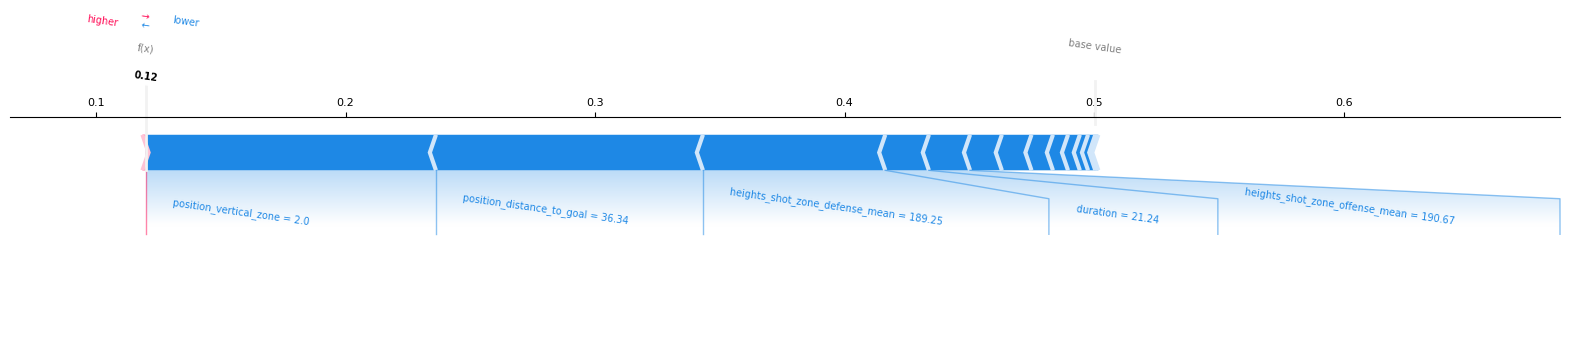

### 2. Cross into the penalty area by Ihlas Bebou (gets deflected by a defender and to the other horizontal side of the pitch, creates disorder in the defense)

<Figure size 640x480 with 0 Axes>

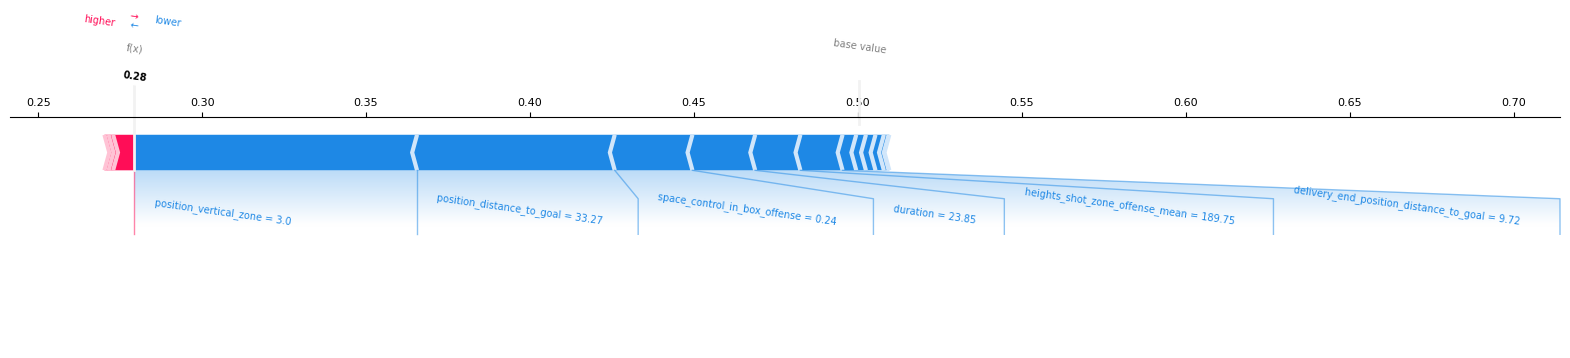

### 3. Marius Bülter receives the ball and directly plays a high pass over to Wout Weghorst, changing horizontal side of the pitch again and further disorienting the defense

<Figure size 640x480 with 0 Axes>

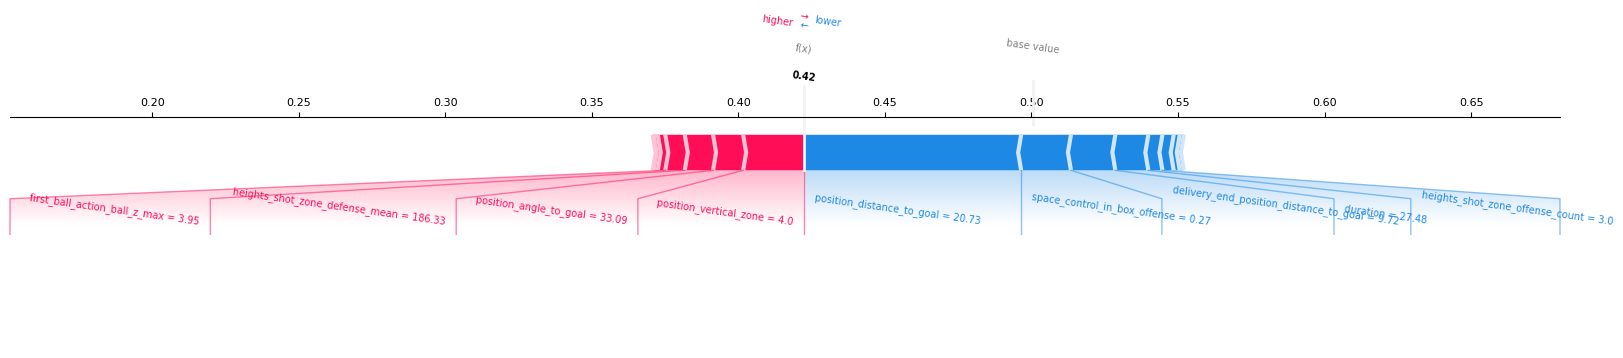

### 4. Weghorst can head the ball into goal from close distance without any defenders disturbing him.

<Figure size 640x480 with 0 Axes>

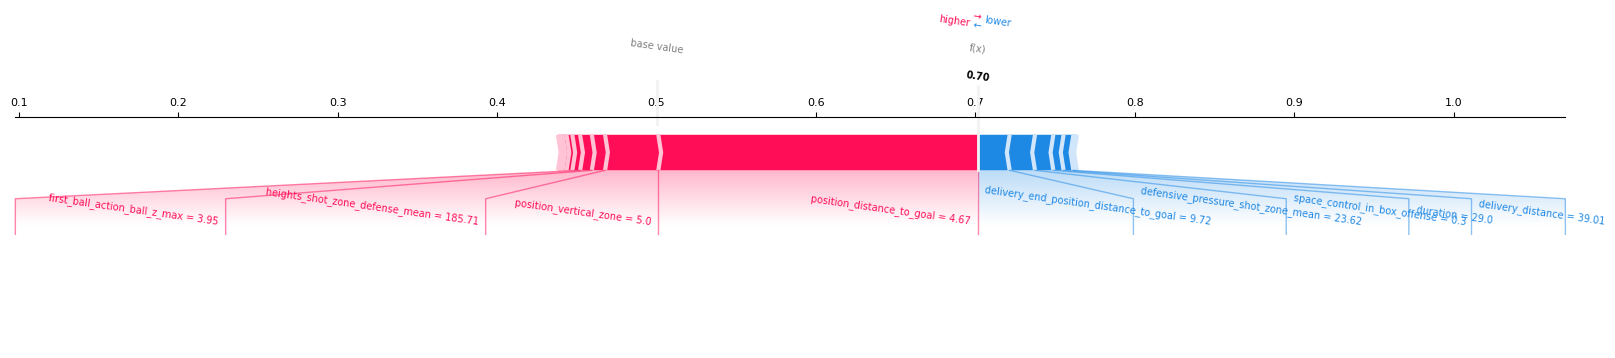

In [ ]:

# Create renamed and rounded version of the sample

descriptions = [
    "1. Pass by Kevin Vogt to Ihlas Bebou (way outside the penalty area, defense is organized)",
    "2. Cross into the penalty area by Ihlas Bebou (gets deflected by a defender and to the other horizontal side of the pitch, creates disorder in the defense)",
    "3. Marius Bülter receives the ball and directly plays a high pass over to Wout Weghorst, changing horizontal side of the pitch again and further disorienting the defense",
    "4. Weghorst can head the ball into goal from close distance without any defenders disturbing him."
]

def clean_sample(sample_series):
    sample_clean = sample_series.copy()
    sample_clean.index = [name.replace("sp_", "") for name in sample_clean.index]
    sample_clean = sample_clean.round(2)
    return sample_clean

for i, sample_idx in enumerate(row_numbers):
    sample = X_test_top15.iloc[sample_idx]
    sample_clean = clean_sample(sample)

    shap_values_sample = shap_values_rf[sample_idx]

    # Align SHAP values to cleaned features
    shap_values_clean = shap.Explanation(
        values=shap_values_sample.values,
        base_values=shap_values_sample.base_values,
        data=sample_clean.values,
        feature_names=sample_clean.index.tolist()
    )

    # Generate (and save) the force plot
    fig = plt.figure()
    shap.force_plot(
        shap_values_clean.base_values,
        shap_values_clean.values,
        shap_values_clean.data,
        feature_names=shap_values_clean.feature_names,
        matplotlib=True,
        show=False  # Don't auto-render
    )

    # Reduce font size for all text elements
    for text in plt.gca().texts:
        text.set_fontsize(7)  # Adjust as needed
        text.set_rotation(-8)
        # text.set_horizontalalignment('left')  # Align text to the left from its anchor point
        # text.set_verticalalignment('center')

    # plt.title(descriptions[i], fontsize=8, fontweight="bold")
    # plt.savefig(f"shap_force_plot_{i+1}.png", bbox_inches='tight')

    display(Markdown(f'### {descriptions[i]}'))
    # Show the figure
    plt.show()
    
    plt.close()


In the force plots we can see the key action that created danger was direct pass by Bülter to Weghorst (action 3), as it brought the ball closer to goal (impact of $\verb|sp_position_distance_to_goal|$ shifts between action 3 and 4) and also increased the space control of Hoffenheim in the penalty area (impact of $\verb|sp_space_control_in_box_offense|$ shifts between action 3 and 4).

This example force plot confirms that the most influence on the model is created by features about the distance of the ball to the goal. To gain more insights about the other, tactically motivated features, a new model could either be trained without information about the distance to goal or with at least removing one of the respective features ($\verb|sp_position_distance_to_goal|$ and $\verb|sp_position_vertical_zone|$) 